# 📊 Phase 2: Exploratory Data Analysis (EDA) & Core Metrics Calculation

## Sub-Phase: Exploratory Data Analysis (EDA)

This notebook is dedicated to conducting an Exploratory Data Analysis (EDA) on the `raw_sessions` and `events` tables in Google BigQuery. The primary goal of this EDA is to:

1.  **Understand Data Structure:** Examine table schemas, data types, and overall organization.
2.  **Assess Data Quality:** Identify missing values, anomalies, and potential inconsistencies.
3.  **Uncover Data Characteristics:** Analyze distributions of key variables (numerical and categorical).
4.  **Identify Relationships:** Explore correlations and patterns between different attributes.
5.  **Derive Initial Insights:** Formulate preliminary hypotheses about user behavior and data trends, which will guide subsequent analysis and predictive modeling.

This foundational understanding is crucial for ensuring the reliability of downstream product metrics and the effectiveness of any predictive models.

# --- 1. Import Necessary Libraries ---

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
import uuid
import hashlib # For simulating FARM_FINGERPRINT
import os

In [6]:
# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['figure.dpi'] = 100

# --- 2. Define Data Paths ---

In [7]:
RAW_CSV_FILE = r'../data/raw/cleaned_speakers_data.csv'

In [8]:
print(f"Loading raw data from: {RAW_CSV_FILE}")

# --- 3. Load Raw CSV Data into df_raw_sessions ---
try:
    df_raw_sessions = pd.read_csv(RAW_CSV_FILE)
    print("Raw sessions data loaded successfully into df_raw_sessions.")
    print(f"df_raw_sessions shape: {df_raw_sessions.shape}")
except FileNotFoundError:
    print(f"Error: {RAW_CSV_FILE} not found. Please ensure the CSV is in the correct path.")
    # Exit or handle gracefully if file is not found
    exit() # Or raise an error, or create an empty df_raw_sessions

Loading raw data from: ../data/raw/cleaned_speakers_data.csv
Raw sessions data loaded successfully into df_raw_sessions.
df_raw_sessions shape: (30000, 24)


# --- 4. Simulate BigQuery's 01_feature_engineering_events.sql to Create df_events ---  
Simulating feature engineering to create df_events...

In [9]:
# List of potential event types that will be "unnested" from each session
event_types_to_unnest = ['session_start', 'session_end', 'conversion_event', 'coupon_event', 'signin_event', 'bounce_event']

# Create a DataFrame for event types to simulate CROSS JOIN UNNEST
df_event_types = pd.DataFrame(event_types_to_unnest, columns=['event_type_derived'])

# Perform the cross join to create a row for each potential event in each session
# This replicates the BigQuery CROSS JOIN UNNEST behavior
df_events_raw = df_raw_sessions.assign(key=1).merge(df_event_types.assign(key=1), on='key').drop('key', axis=1)

# Filter events based on conditions, similar to BigQuery's WHERE clause
df_events_filtered = df_events_raw[
    ((df_events_raw['event_type_derived'] == 'conversion_event') & (df_events_raw['conversion_flag'] == 1)) |
    ((df_events_raw['event_type_derived'] == 'coupon_event') & (df_events_raw['coupon_applied'] == 'Yes')) |
    ((df_events_raw['event_type_derived'] == 'signin_event') & (df_events_raw['sign_in'] == 'Email')) |
    ((df_events_raw['event_type_derived'] == 'bounce_event') & (df_events_raw['bounce_flag'] == 1)) |
    (df_events_raw['event_type_derived'].isin(['session_start', 'session_end']))
].copy() # Use .copy() to avoid SettingWithCopyWarning

# Define the final event_name based on the logic from SQL script
df_events_filtered['event_name'] = df_events_filtered.apply(lambda row:
    'coupon_applied' if row['coupon_applied'] == 'Yes' else
    'purchase_completed' if row['conversion_flag'] == 1 and row['conversion_type'] == 'Purchase' else
    'signup_completed' if row['conversion_flag'] == 1 and row['conversion_type'] == 'Signup' else
    'signed_in_event' if row['sign_in'] == 'Email' else
    'bounced_session_event' if row['bounce_flag'] == 1 else
    'session_start' if row['event_type_derived'] == 'session_start' else
    'session_end' if row['event_type_derived'] == 'session_end' else
    'other_event', axis=1
)

# Generate event_timestamp (simulating SQL's TIMESTAMP_ADD and FARM_FINGERPRINT)
# Base timestamp for the entire dataset spread (arbitrary for simulation)
base_start_date_seconds = pd.Timestamp('2024-01-01 00:00:00 UTC').timestamp()

# Simulate FARM_FINGERPRINT: simple hash of session_id
df_events_filtered['session_hash_offset'] = df_events_filtered['session_id'].apply(
    lambda x: int(hashlib.sha256(str(x).encode('utf-8')).hexdigest(), 16) % (365 * 24 * 60 * 60)
)

df_events_filtered['event_timestamp_seconds'] = df_events_filtered.apply(lambda row:
    base_start_date_seconds + row['session_hash_offset'] + (
        0 if row['event_name'] == 'session_start' else
        row['time_spent'] * 60 if row['event_name'] == 'session_end' else
        row['time_spent'] * 60 * 0.9 if row['event_name'] == 'purchase_completed' else
        row['time_spent'] * 60 * 0.5 if row['event_name'] == 'signup_completed' else
        row['time_spent'] * 60 * 0.3 if row['event_name'] == 'coupon_applied' else
        row['time_spent'] * 60 * 0.1 if row['event_name'] == 'signed_in_event' else
        row['time_spent'] * 60 * 0.05 if row['event_name'] == 'bounced_session_event' else
        0
    ), axis=1
)

# Convert timestamp seconds to datetime objects for easier use in Python
df_events_filtered['event_timestamp'] = pd.to_datetime(df_events_filtered['event_timestamp_seconds'], unit='s', utc=True)

# Generate event_id
df_events_filtered['event_id'] = [str(uuid.uuid4()) for _ in range(len(df_events_filtered))]

# Select and rename final columns for df_events to match BigQuery output schema
df_events = df_events_filtered[[
    'event_id',
    'user_id',
    'session_id',
    'event_timestamp', # Now datetime object
    'event_name',
    'name', # user_name
    'demographic_age', # user_demographic_age
    'demographic_age_group', # user_demographic_age_group
    'demographic_gender', # user_demographic_gender
    'email', # user_email
    'location', # user_location
    'country', # user_country
    'sign_in', # used for user_is_signed_in_session
    'bounce_flag', # used for user_is_bounced_session
    'device_type', # event_property_device_type
    'traffic_source', # event_property_traffic_source
    'pages_visited', # event_property_pages_visited
    'revenue', # event_property_revenue
    'product_purchased', # event_property_product_purchased
    'coupon_applied', # used for event_property_coupon_applied_flag
    'time_spent', # used for event_property_time_spent_seconds
    'variant_group', # event_property_variant_group
    'payment_type', # event_property_payment_type
    'card_type' # event_property_card_type
]].rename(columns={
    'name': 'user_name',
    'demographic_age': 'user_demographic_age',
    'demographic_age_group': 'user_demographic_age_group',
    'demographic_gender': 'user_demographic_gender',
    'email': 'user_email',
    'location': 'user_location',
    'country': 'user_country',
    'device_type': 'event_property_device_type',
    'traffic_source': 'event_property_traffic_source',
    'pages_visited': 'event_property_pages_visited',
    'revenue': 'event_property_revenue',
    'product_purchased': 'event_property_product_purchased',
    'time_spent': 'event_property_time_spent_seconds', # Will convert to seconds below
    'variant_group': 'event_property_variant_group',
    'payment_type': 'event_property_payment_type',
    'card_type': 'event_property_card_type'
})

# Add derived boolean flags
df_events['user_is_signed_in_session'] = (df_events['sign_in'] == 'Email')
df_events['user_is_bounced_session'] = (df_events['bounce_flag'] == 1)
df_events['event_property_coupon_applied_flag'] = (df_events['coupon_applied'] != 'ND')

# Convert time_spent from minutes to seconds for event_property_time_spent_seconds
df_events['event_property_time_spent_seconds'] = df_events['event_property_time_spent_seconds'] * 60

# Drop original intermediate columns that are no longer needed
df_events = df_events.drop(columns=['sign_in', 'bounce_flag', 'coupon_applied'])


print("df_events created successfully, simulating BigQuery transformation.")
print(f"df_events shape: {df_events.shape}")

print("\nData loading and engineering simulation complete. Ready for EDA!")

df_events created successfully, simulating BigQuery transformation.
df_events shape: (92048, 24)

Data loading and engineering simulation complete. Ready for EDA!


# --- 5. Basic Data Overview ---  
--- Overview of df_raw_sessions (Raw Sessions Data) ---

In [10]:
print("\nShape (Rows, Columns):", df_raw_sessions.shape)


Shape (Rows, Columns): (30000, 24)


In [11]:
print("\nFirst 5 rows:")
df_raw_sessions.head()


First 5 rows:


,user_id,session_id,sign_in,name,demographic_age,demographic_age_group,demographic_gender,email,location,country,...,pages_visited,conversion_flag,conversion_type,traffic_source,product_purchased,revenue,payment_type,card_type,coupon_applied,bounce_flag
0,U10477,S000001,Email,Victor Navarro-Noël,31,Adult,Female,victornavarronoël251@hotmail.com,Rome,Italy,...,7,0,NCT,Organic,NPP,0.0,NPT,NCAT,ND,1
1,U01536,S000002,Email,王秀云,39,Adult,Female,王秀云617@gmail.com,Madrid,Spain,...,5,0,NCT,Social,NPP,0.0,NPT,NCAT,ND,0
2,U00107,S000003,Guest,Ucchal Sabharwal,68,Old,Male,Not Provided,Manchester,UK,...,7,0,NCT,Organic,NPP,0.0,NPT,NCAT,ND,0
3,U13886,S000004,Email,Virginie Schmitt,72,Old,Female,virginieschmitt827@gmail.com,Sydney,Australia,...,10,0,NCT,Social,NPP,0.0,NPT,NCAT,ND,0
4,U05926,S000005,Email,Cynthia Drake,51,Adult,No Answer,cynthiadrake47@hotmail.com,Mumbai,India,...,6,0,NCT,Organic,NPP,0.0,NPT,NCAT,ND,0


In [12]:
print("\nGeneral Info (Column types, Non-null counts):")
df_raw_sessions.info(verbose=True, show_counts=True) # verbose=True and show_counts=True provide more detailed info


General Info (Column types, Non-null counts):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                30000 non-null  object 
 1   session_id             30000 non-null  object 
 2   sign_in                30000 non-null  object 
 3   name                   30000 non-null  object 
 4   demographic_age        30000 non-null  int64  
 5   demographic_age_group  30000 non-null  object 
 6   demographic_gender     30000 non-null  object 
 7   email                  30000 non-null  object 
 8   location               30000 non-null  object 
 9   country                30000 non-null  object 
 10  device_type            30000 non-null  object 
 11  timestamp              30000 non-null  object 
 12  variant_group          30000 non-null  object 
 13  time_spent             30000 non-null  float64
 14  pages_v

In [22]:
print("\nDescriptive Statistics for Numerical Columns:")
df_raw_sessions.describe(include='number') # include='all' to see stats for object/categorical columns too


Descriptive Statistics for Numerical Columns:


,demographic_age,time_spent,pages_visited,conversion_flag,revenue,bounce_flag
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,46.905533,10.524185,5.501467,0.151167,26.208553,0.189067
std,19.405500,5.481363,2.874208,0.358217,137.294872,0.391568
min,14.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,30.000000,5.780000,3.000000,0.000000,0.000000,0.000000
50%,47.000000,10.580000,5.000000,0.000000,0.000000,0.000000
75%,64.000000,15.270000,8.000000,0.000000,0.000000,0.000000
max,80.000000,20.000000,10.000000,1.000000,2499.000000,1.000000


In [23]:
print("\nMissing Values Count:")
df_raw_sessions.isnull().sum().sort_values(ascending=False)


Missing Values Count:


user_id                  0
session_id               0
sign_in                  0
name                     0
demographic_age          0
demographic_age_group    0
demographic_gender       0
email                    0
location                 0
country                  0
device_type              0
timestamp                0
variant_group            0
time_spent               0
pages_visited            0
conversion_flag          0
conversion_type          0
traffic_source           0
product_purchased        0
revenue                  0
payment_type             0
card_type                0
coupon_applied           0
bounce_flag              0
dtype: int64

In [24]:
print("\nUnique Values and Cardinality:")
for col in df_raw_sessions.columns:
    unique_count = df_raw_sessions[col].nunique()
    print(f"- {col}: {unique_count} unique values")
    if unique_count < 20 and df_raw_sessions[col].dtype == 'object': # Show value counts for low-cardinality string columns
        print(f"  Top values: {df_raw_sessions[col].value_counts().head(5).to_dict()}")
    elif unique_count < 10 and df_raw_sessions[col].dtype in ['int64', 'float64']: # Show value counts for low-cardinality numerical columns
        print(f"  Top values: {df_raw_sessions[col].value_counts().head(5).to_dict()}")


Unique Values and Cardinality:
- user_id: 12984 unique values
- session_id: 30000 unique values
- sign_in: 2 unique values
  Top values: {'Email': 20975, 'Guest': 9025}
- name: 23706 unique values
- demographic_age: 67 unique values
- demographic_age_group: 3 unique values
  Top values: {'Adult': 20139, 'Old': 7156, 'Teenage': 2705}
- demographic_gender: 3 unique values
  Top values: {'Male': 13606, 'Female': 13487, 'No Answer': 2907}
- email: 20974 unique values
- location: 26 unique values
- country: 15 unique values
  Top values: {'India': 3529, 'USA': 3444, 'Canada': 2374, 'UK': 2324, 'Japan': 2323}
- device_type: 3 unique values
  Top values: {'Mobile': 18008, 'Desktop': 8953, 'Tablet': 3039}
- timestamp: 20355 unique values
- variant_group: 3 unique values
  Top values: {'Vibrant': 10046, 'Heat': 10026, 'Cold': 9928}
- time_spent: 1901 unique values
- pages_visited: 10 unique values
- conversion_flag: 2 unique values
  Top values: {0: 25465, 1: 4535}
- conversion_type: 3 unique 

--- Overview of df_events (Engineered Events Data) ---

In [25]:
print("\nShape (Rows, Columns):", df_events.shape)


Shape (Rows, Columns): (92048, 24)


In [26]:
print("\nFirst 5 rows:")
df_events.head()


First 5 rows:


,event_id,user_id,session_id,event_timestamp,event_name,user_name,user_demographic_age,user_demographic_age_group,user_demographic_gender,user_email,...,event_property_pages_visited,event_property_revenue,event_property_product_purchased,event_property_time_spent_seconds,event_property_variant_group,event_property_payment_type,event_property_card_type,user_is_signed_in_session,user_is_bounced_session,event_property_coupon_applied_flag
0,3a027c14-402f-47a9-b202-a7c86c0e1ec0,U10477,S000001,2024-08-27 03:02:10.900000095+00:00,signed_in_event,Victor Navarro-Noël,31,Adult,Female,victornavarronoël251@hotmail.com,...,7,0.0,NPP,159.0,Heat,NPT,NCAT,True,True,False
1,79cbc482-972f-44f2-b8a2-62e1866fb5de,U10477,S000001,2024-08-27 03:02:10.900000095+00:00,signed_in_event,Victor Navarro-Noël,31,Adult,Female,victornavarronoël251@hotmail.com,...,7,0.0,NPP,159.0,Heat,NPT,NCAT,True,True,False
4,46ef81bb-5f17-40d7-90b7-66617e842a8e,U10477,S000001,2024-08-27 03:02:10.900000095+00:00,signed_in_event,Victor Navarro-Noël,31,Adult,Female,victornavarronoël251@hotmail.com,...,7,0.0,NPP,159.0,Heat,NPT,NCAT,True,True,False
5,aaac22ed-dc91-4ab3-b13c-04773d1e77ea,U10477,S000001,2024-08-27 03:02:10.900000095+00:00,signed_in_event,Victor Navarro-Noël,31,Adult,Female,victornavarronoël251@hotmail.com,...,7,0.0,NPP,159.0,Heat,NPT,NCAT,True,True,False
6,0906bcf1-2e35-4fc5-aa4f-69981f2af5c9,U01536,S000002,2024-01-16 19:02:03.180000067+00:00,signed_in_event,王秀云,39,Adult,Female,王秀云617@gmail.com,...,5,0.0,NPP,571.8,Vibrant,NPT,NCAT,True,False,False


In [27]:
print("\nGeneral Info (Column types, Non-null counts):")
df_events.info(verbose=True, show_counts=True)


General Info (Column types, Non-null counts):
<class 'pandas.core.frame.DataFrame'>
Index: 92048 entries, 0 to 179998
Data columns (total 24 columns):
 #   Column                              Non-Null Count  Dtype              
---  ------                              --------------  -----              
 0   event_id                            92048 non-null  object             
 1   user_id                             92048 non-null  object             
 2   session_id                          92048 non-null  object             
 3   event_timestamp                     92048 non-null  datetime64[ns, UTC]
 4   event_name                          92048 non-null  object             
 5   user_name                           92048 non-null  object             
 6   user_demographic_age                92048 non-null  int64              
 7   user_demographic_age_group          92048 non-null  object             
 8   user_demographic_gender             92048 non-null  object             
 

In [28]:
print("\nDescriptive Statistics for Numerical Columns:")
df_events.describe(include='number')


Descriptive Statistics for Numerical Columns:


,user_demographic_age,event_property_pages_visited,event_property_revenue,event_property_time_spent_seconds
count,92048.000000,92048.000000,92048.000000,92048.000000
mean,46.933133,5.369220,34.399484,631.519822
std,19.402901,2.932256,156.801083,328.851979
min,14.000000,1.000000,0.000000,60.000000
25%,30.000000,3.000000,0.000000,346.800000
50%,47.000000,5.000000,0.000000,634.800000
75%,64.000000,8.000000,0.000000,916.200000
max,80.000000,10.000000,2499.000000,1200.000000


In [29]:
print("\nMissing Values Count:")
df_events.isnull().sum().sort_values(ascending=False)


Missing Values Count:


event_id                              0
user_id                               0
session_id                            0
event_timestamp                       0
event_name                            0
user_name                             0
user_demographic_age                  0
user_demographic_age_group            0
user_demographic_gender               0
user_email                            0
user_location                         0
user_country                          0
event_property_device_type            0
event_property_traffic_source         0
event_property_pages_visited          0
event_property_revenue                0
event_property_product_purchased      0
event_property_time_spent_seconds     0
event_property_variant_group          0
event_property_payment_type           0
event_property_card_type              0
user_is_signed_in_session             0
user_is_bounced_session               0
event_property_coupon_applied_flag    0
dtype: int64

In [30]:
print("\nUnique Values and Cardinality:")
for col in df_events.columns:
    unique_count = df_events[col].nunique()
    print(f"- {col}: {unique_count} unique values")
    if unique_count < 20 and df_events[col].dtype == 'object': # Show value counts for low-cardinality string columns
        print(f"  Top values: {df_events[col].value_counts().head(5).to_dict()}")
    elif unique_count < 10 and df_events[col].dtype in ['int64', 'float64']: # Show value counts for low-cardinality numerical columns
        print(f"  Top values: {df_events[col].value_counts().head(5).to_dict()}")


Unique Values and Cardinality:
- event_id: 92048 unique values
- user_id: 12984 unique values
- session_id: 30000 unique values
- event_timestamp: 36181 unique values
- event_name: 7 unique values
  Top values: {'signed_in_event': 56725, 'purchase_completed': 7951, 'signup_completed': 6488, 'session_end': 6182, 'session_start': 6182}
- user_name: 23706 unique values
- user_demographic_age: 67 unique values
- user_demographic_age_group: 3 unique values
  Top values: {'Adult': 61795, 'Old': 21980, 'Teenage': 8273}
- user_demographic_gender: 3 unique values
  Top values: {'Male': 41612, 'Female': 41436, 'No Answer': 9000}
- user_email: 20974 unique values
- user_location: 26 unique values
- user_country: 15 unique values
  Top values: {'India': 10826, 'USA': 10538, 'Canada': 7316, 'UK': 7108, 'Australia': 7090}
- event_property_device_type: 3 unique values
  Top values: {'Mobile': 55235, 'Desktop': 27460, 'Tablet': 9353}
- event_property_traffic_source: 4 unique values
  Top values: {'Or

Basic Data Overview Complete!

# --- 6. Univariate Analysis --- 
--- Univariate Analysis for df_raw_sessions ---

In [31]:
category_columns_df = df_raw_sessions.select_dtypes(include='object')
category_columns_df.columns

Index(['user_id', 'session_id', 'sign_in', 'name', 'demographic_age_group',
       'demographic_gender', 'email', 'location', 'country', 'device_type',
       'timestamp', 'variant_group', 'conversion_type', 'traffic_source',
       'product_purchased', 'payment_type', 'card_type', 'coupon_applied'],
      dtype='object')

In [38]:
# Define numerical and categorical columns for df_raw_sessions
numerical_cols_raw = [
    'demographic_age', 
    'time_spent', 
    'pages_visited', 
    'conversion_flag',
    'revenue', 
    'bounce_flag'
]

categorical_cols_raw = [ 
    'sign_in', 
    'demographic_age_group',
    'demographic_gender',
    'location', 
    'country', 
    'device_type', 
    'variant_group', 
    'conversion_type', 
    'traffic_source', 
    'payment_type',
    'card_type', 
    'coupon_applied'
]


Plotting numerical distributions for df_raw_sessions...


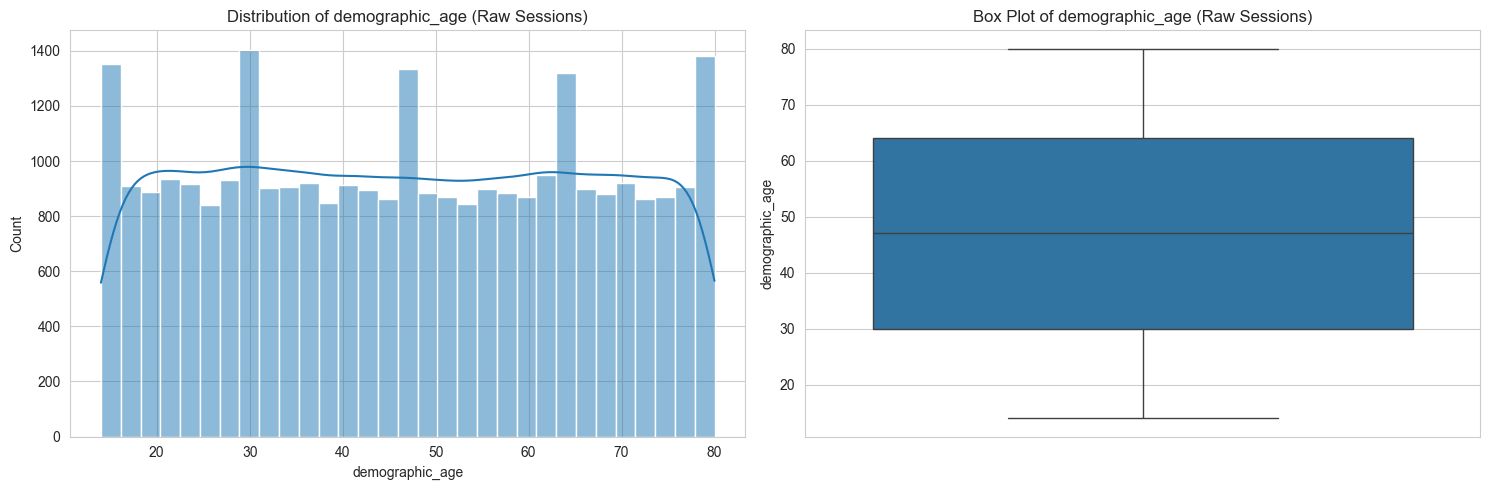

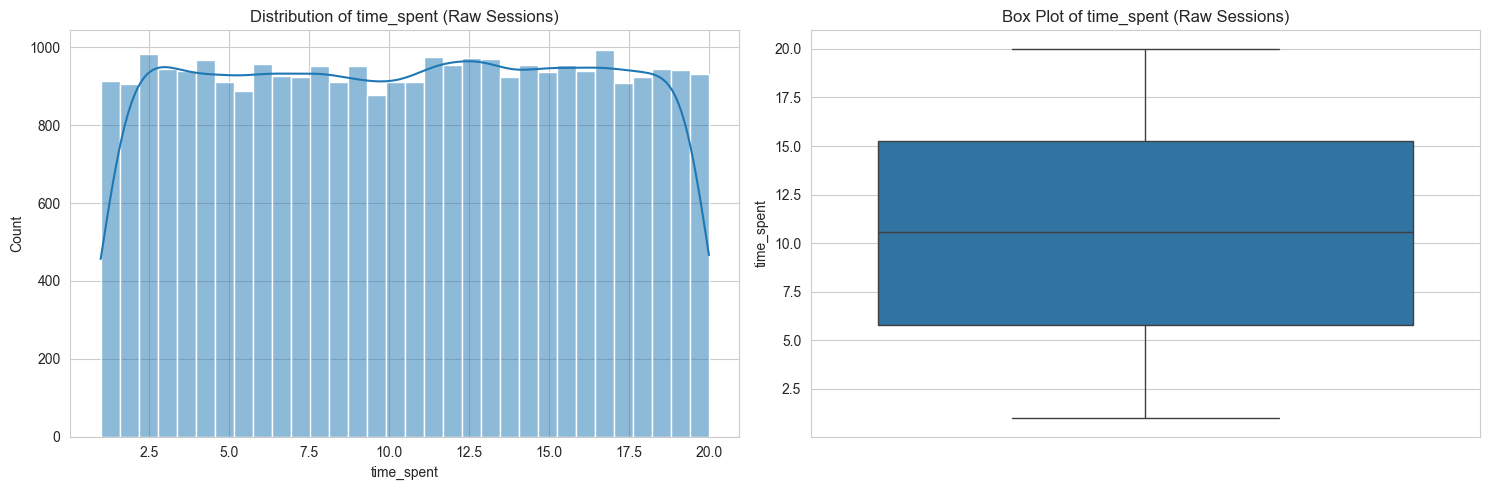

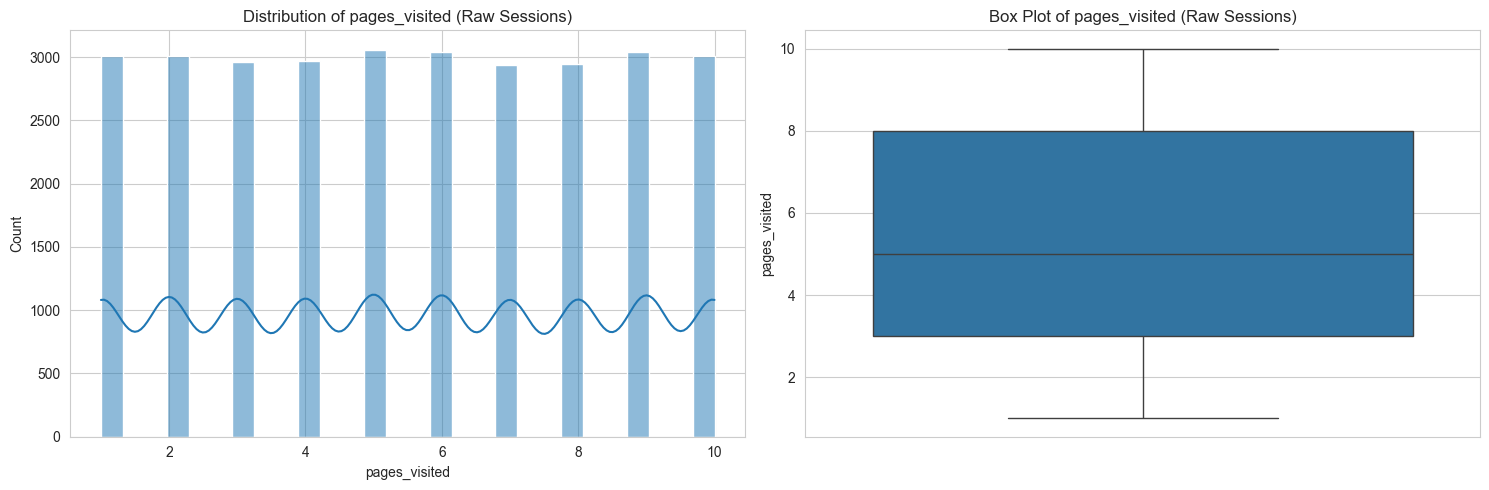

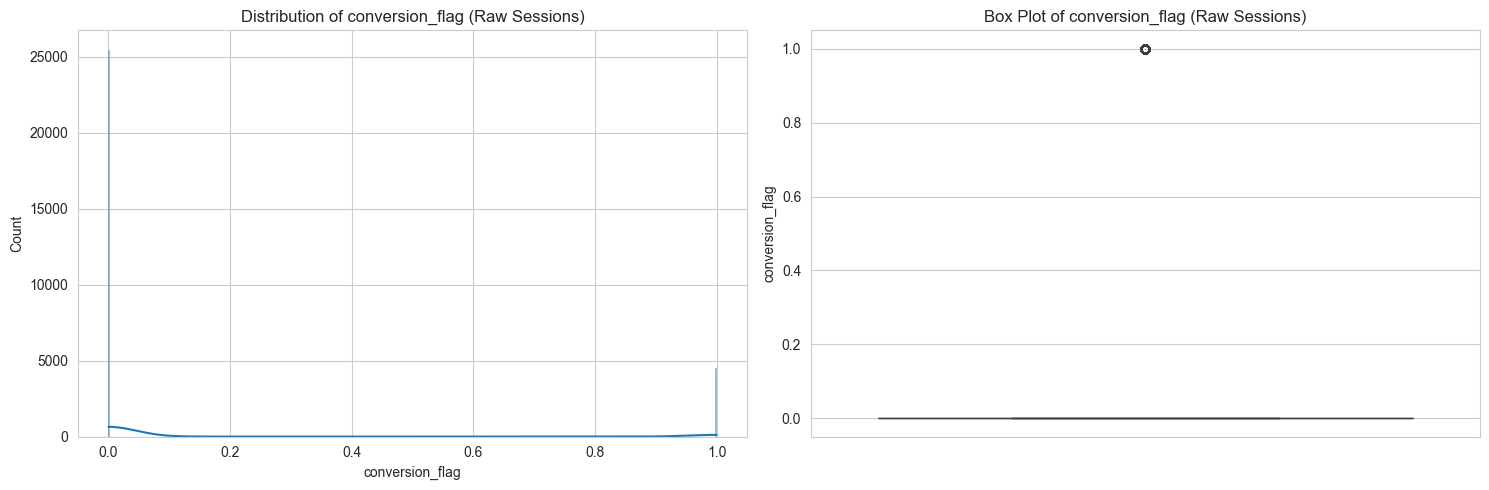

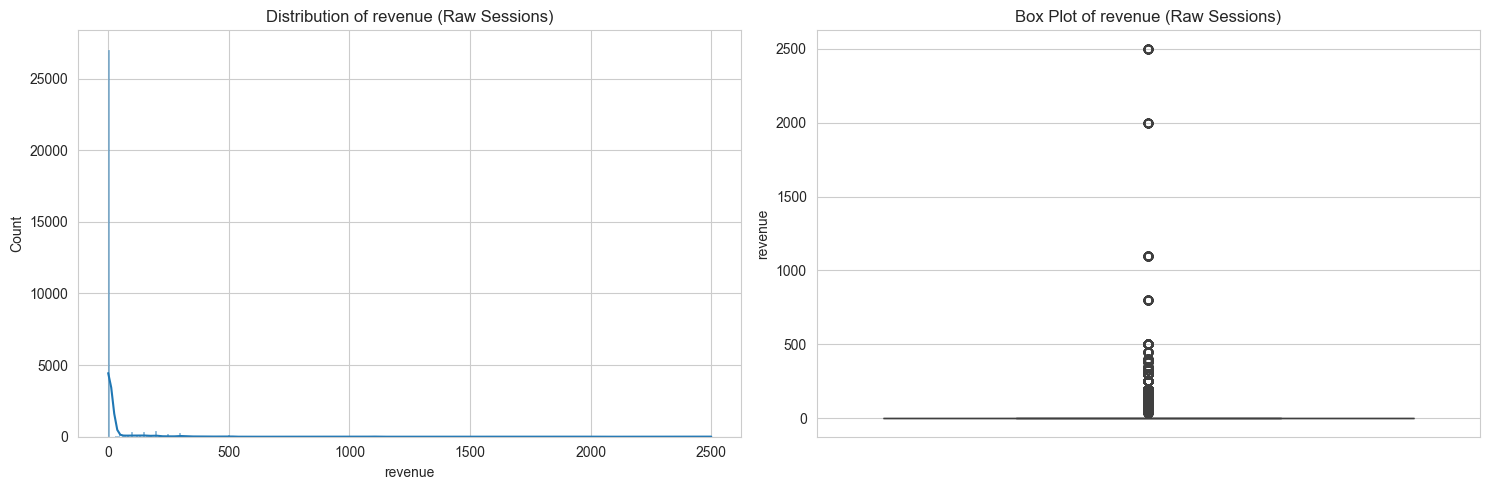

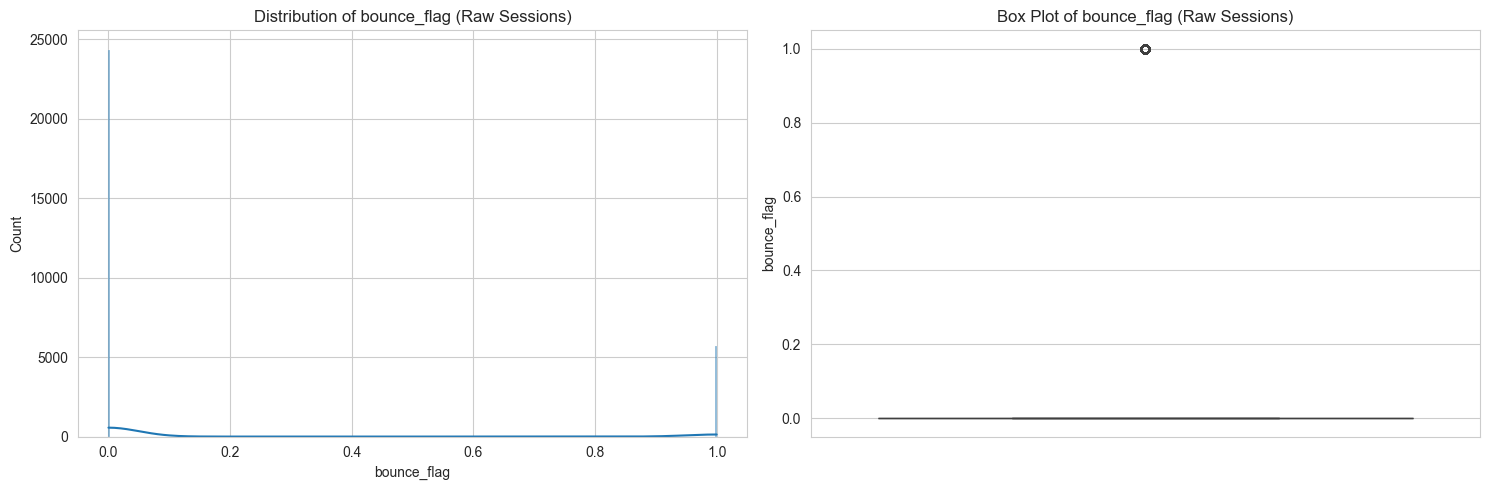

In [39]:
# Plotting Numerical Columns (Histograms and Box Plots) - df_raw_sessions
print("\nPlotting numerical distributions for df_raw_sessions...")
for col in numerical_cols_raw:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    sns.histplot(df_raw_sessions[col], kde=True, ax=axes[0])
    axes[0].set_title(f'Distribution of {col} (Raw Sessions)')
    sns.boxplot(y=df_raw_sessions[col], ax=axes[1])
    axes[1].set_title(f'Box Plot of {col} (Raw Sessions)')
    plt.tight_layout()
    plt.show()


Plotting categorical distributions for df_raw_sessions...


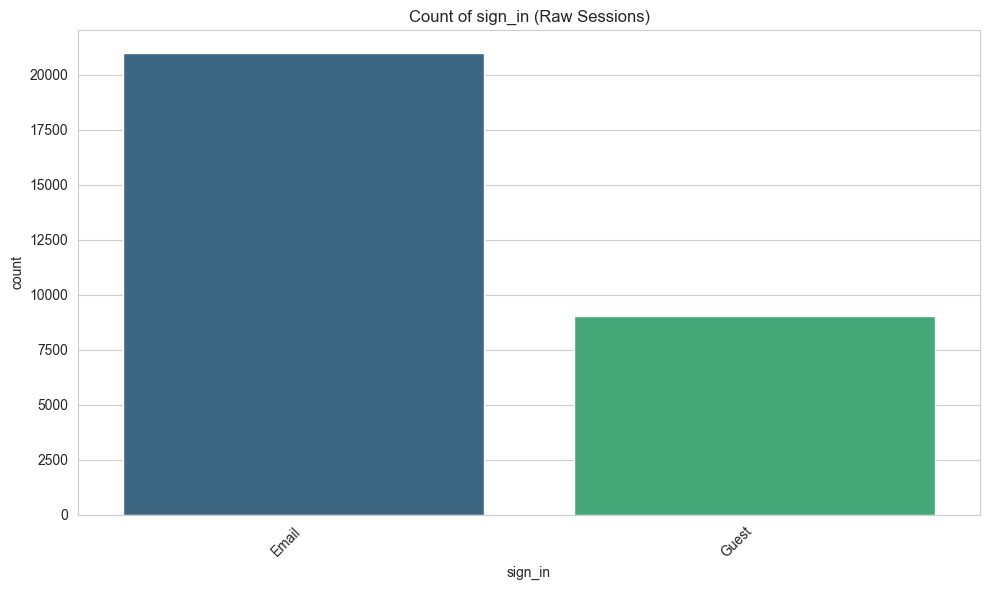

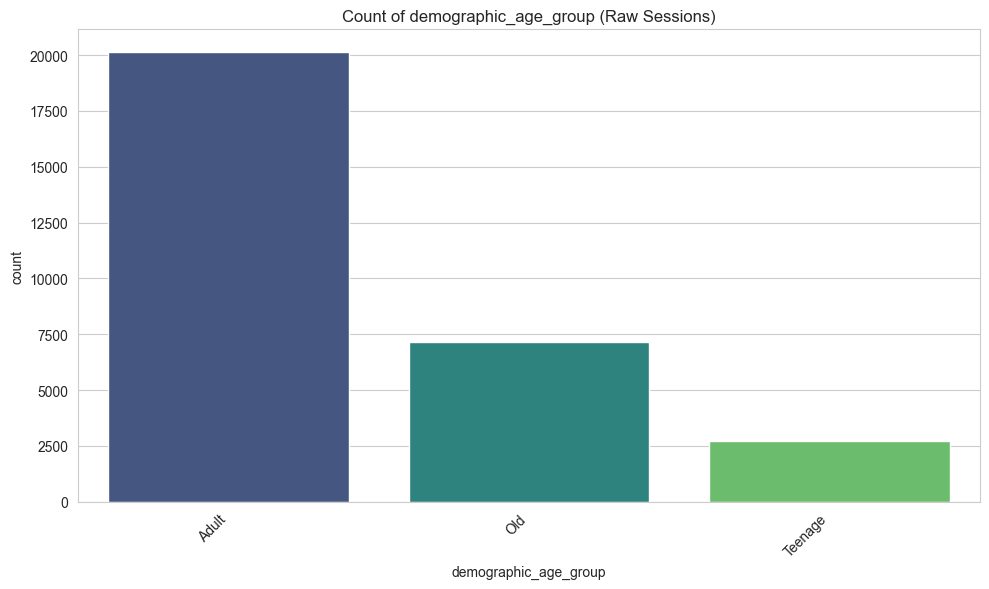

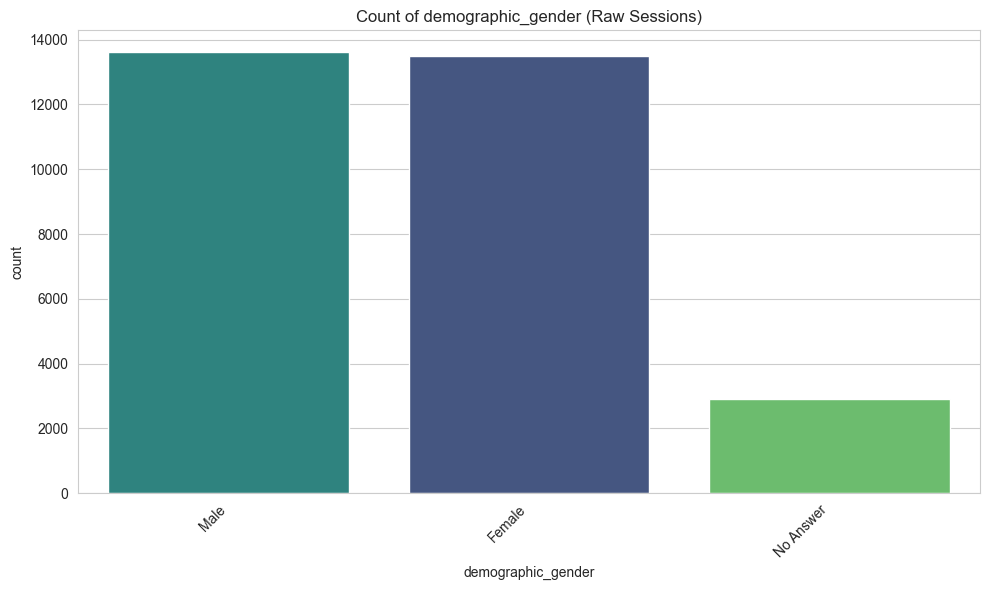

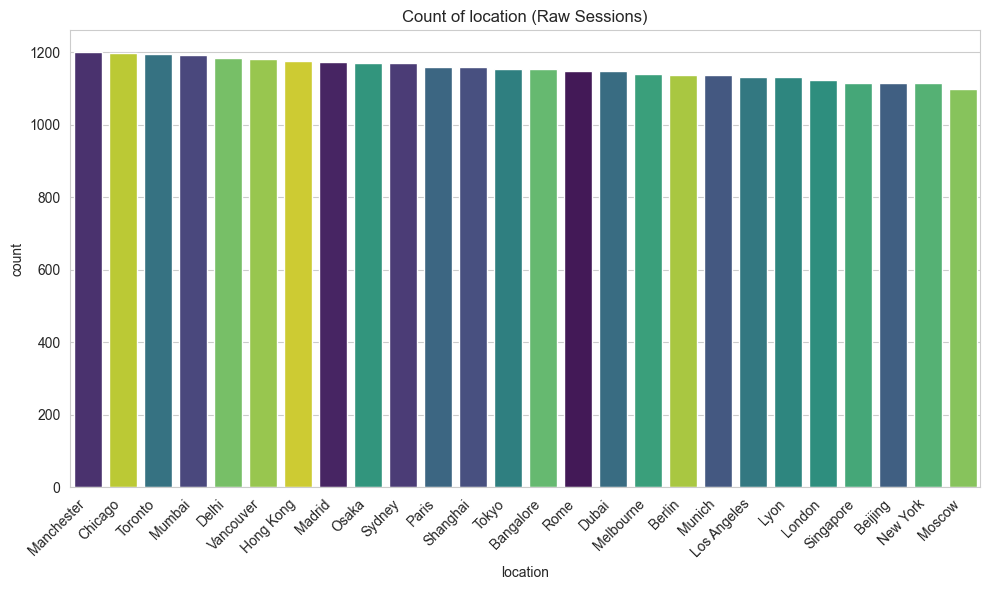

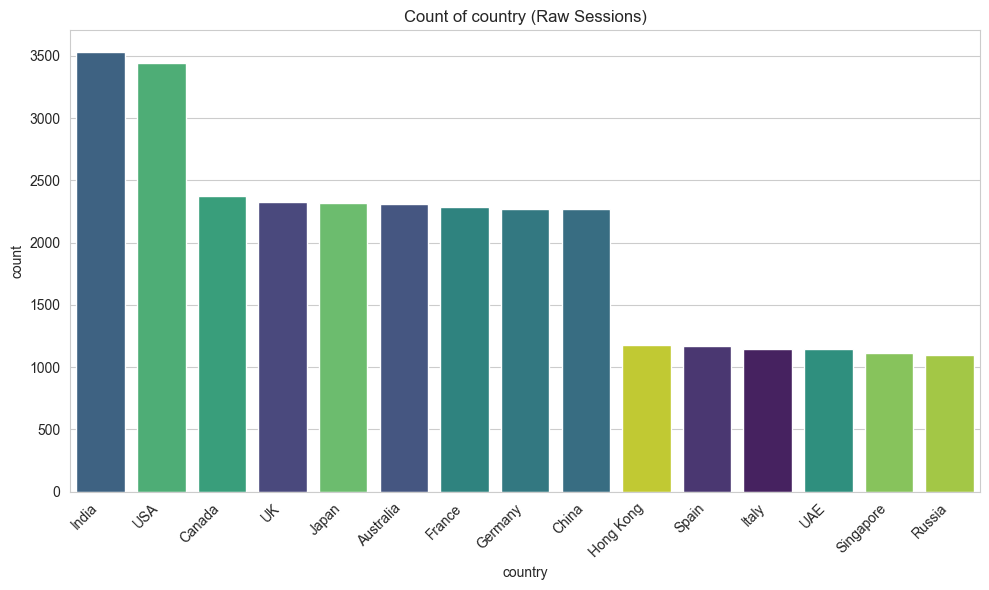

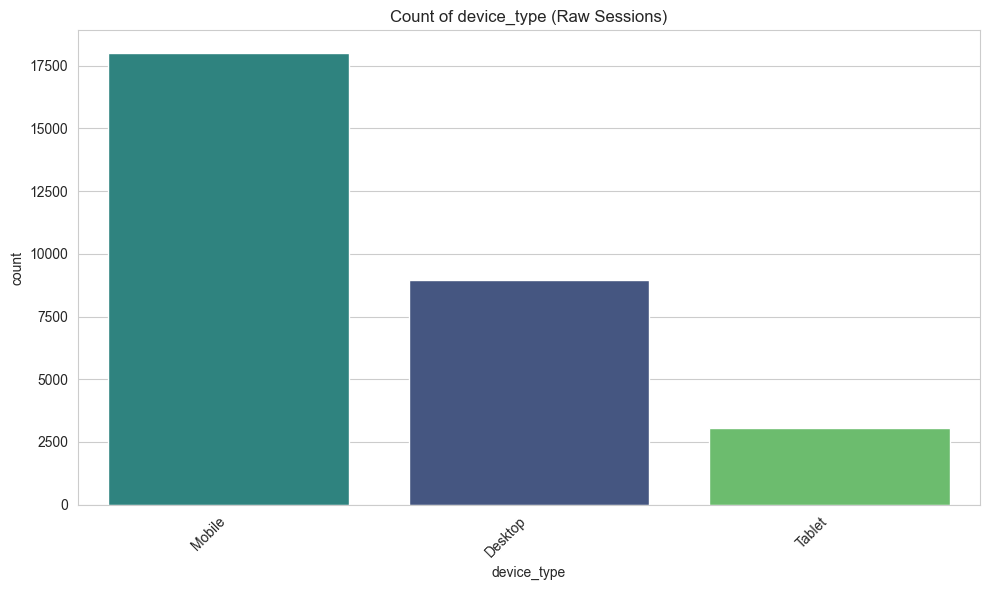

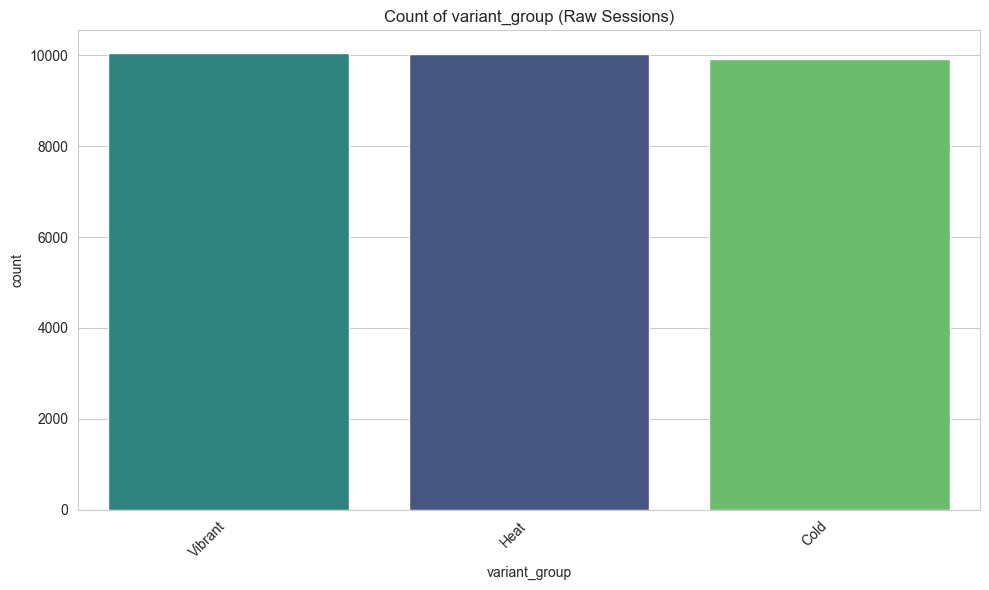

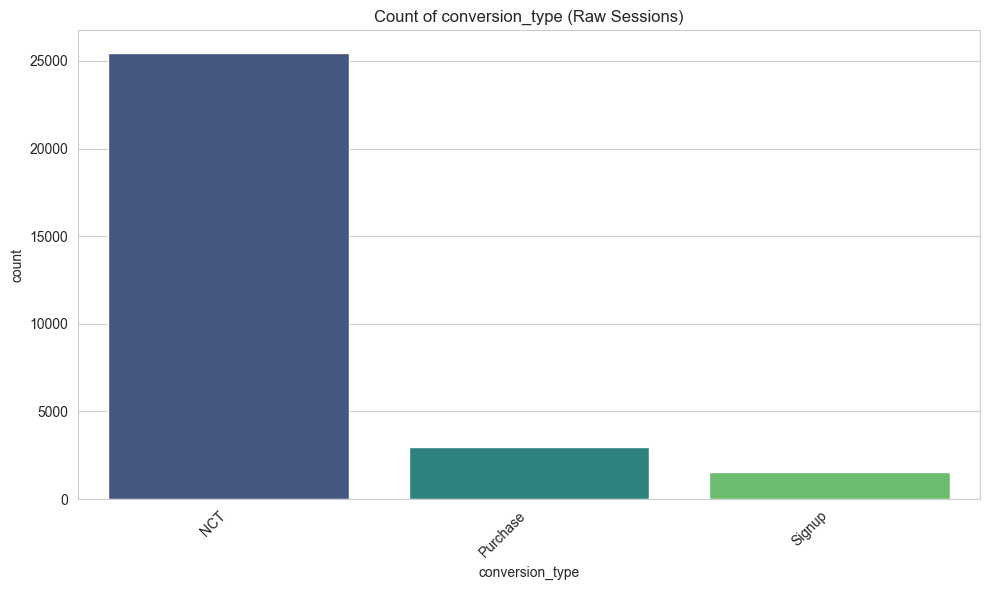

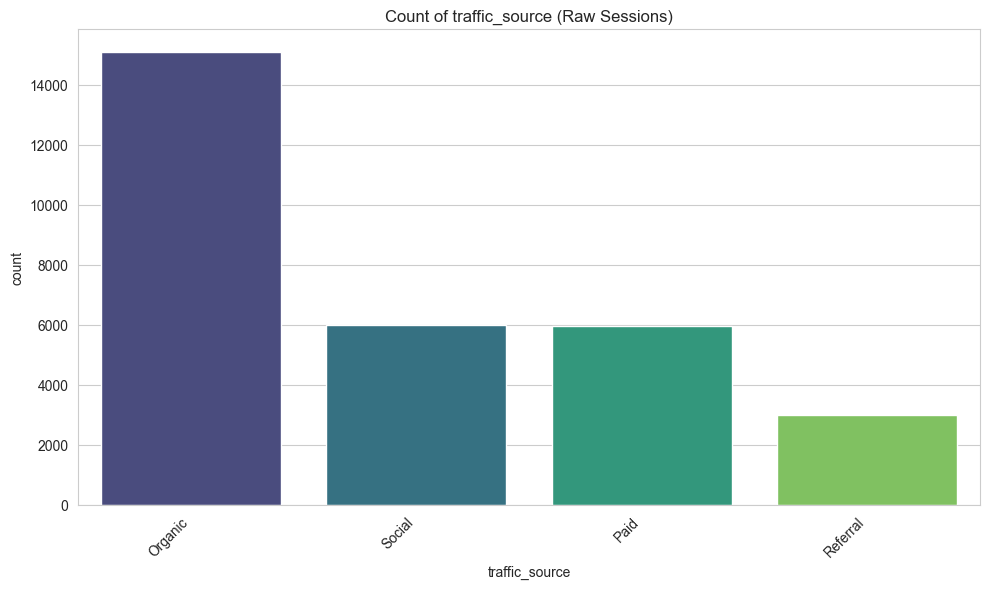

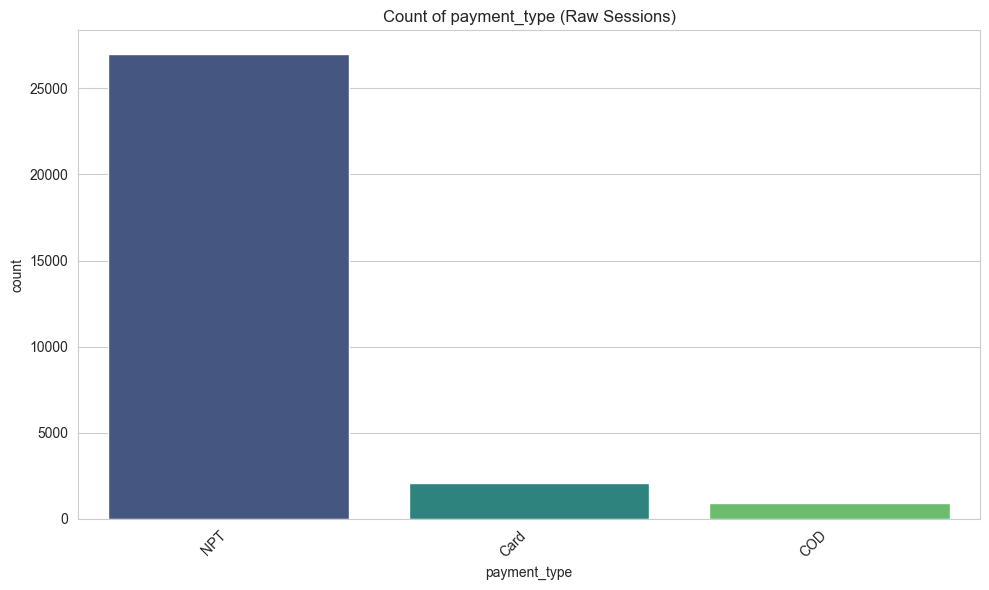

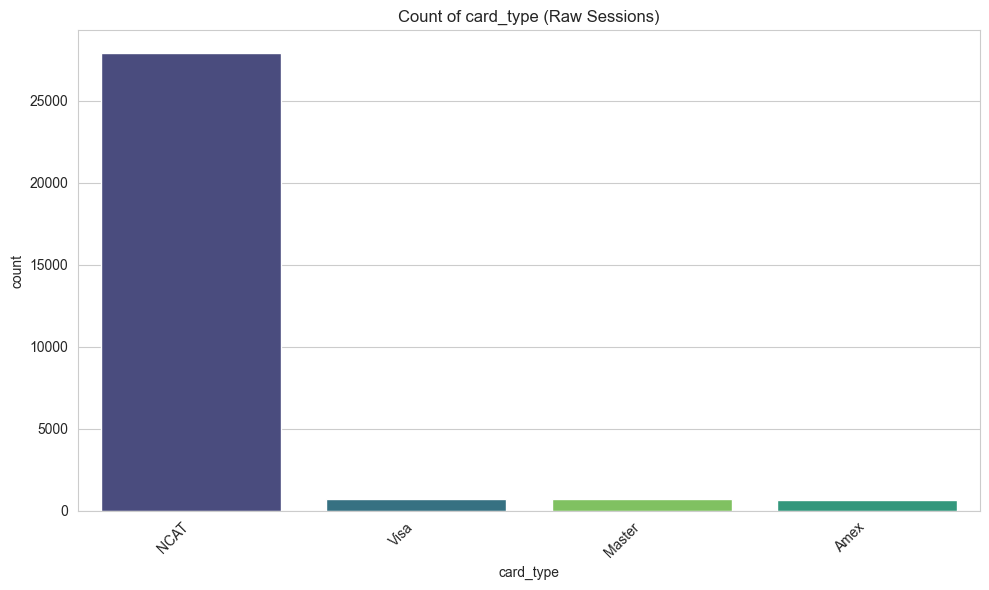

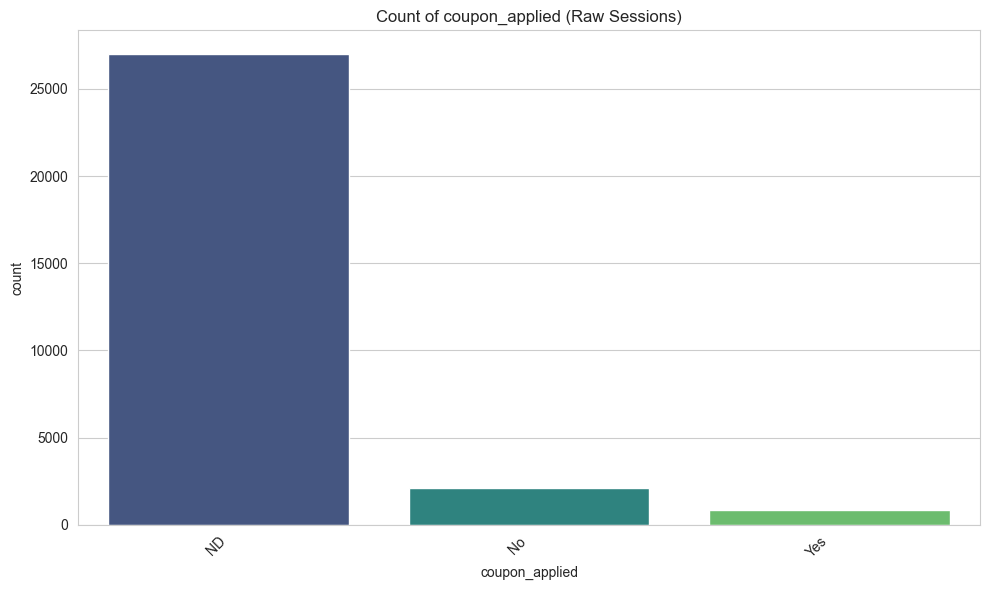

In [40]:
# Plotting Categorical Columns (Count Plots) - df_raw_sessions
print("\nPlotting categorical distributions for df_raw_sessions...")
for col in categorical_cols_raw:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df_raw_sessions, x=col, hue=col, order=df_raw_sessions[col].value_counts().index, palette='viridis', legend=False)
    plt.title(f'Count of {col} (Raw Sessions)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

--- Univariate Analysis for df_events ---

In [47]:
# Define numerical and categorical columns for df_events
numerical_cols_events = [
    'user_demographic_age', 
    'event_property_pages_visited',
    'event_property_revenue', 
    'event_property_time_spent_seconds'
]

categorical_cols_events = [
    'event_name',
    'user_demographic_age_group',
    'user_demographic_gender',
    'user_location', 
    'user_country', 
    'event_property_device_type',
    'event_property_traffic_source',
    'event_property_variant_group', 
    'event_property_payment_type',
    'event_property_card_type'
]


Plotting numerical distributions for df_events...


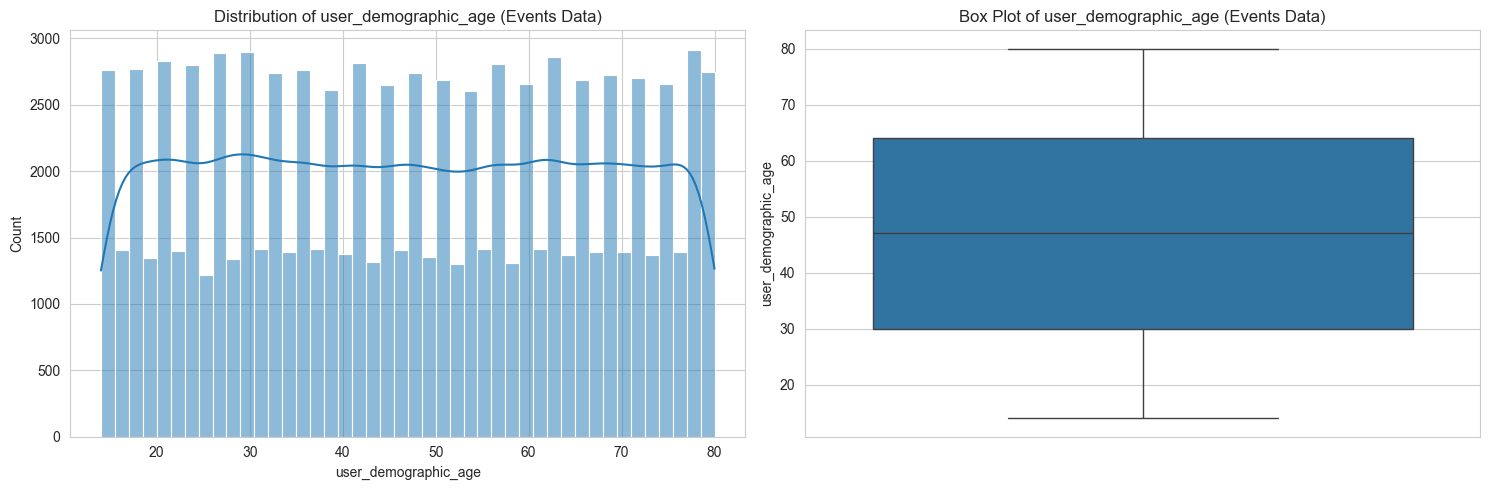

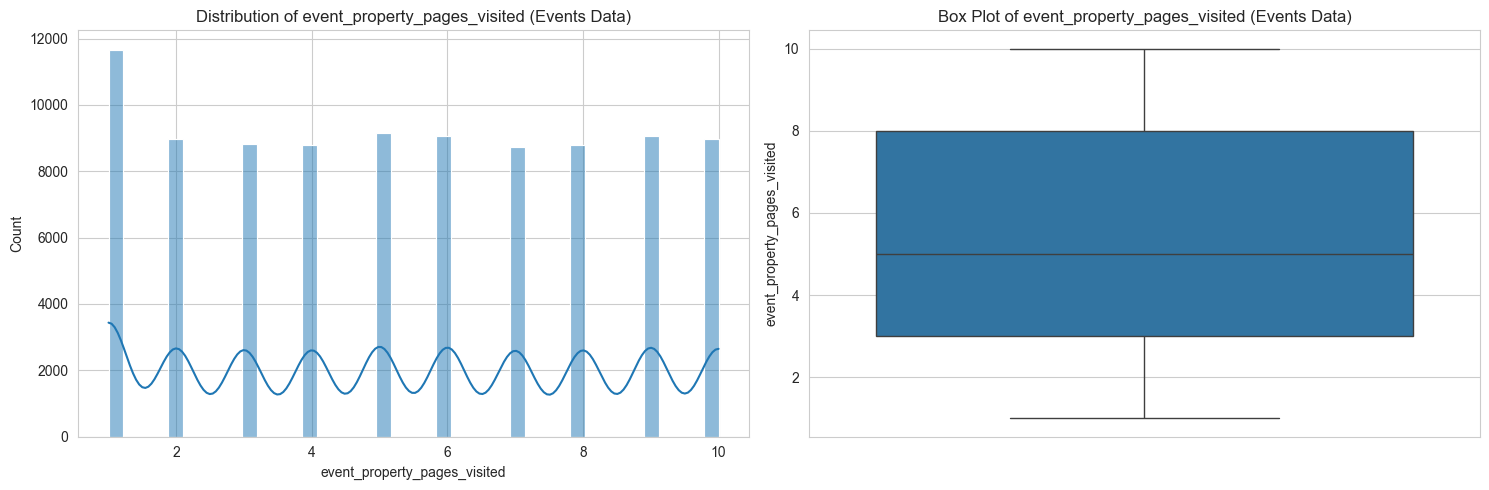

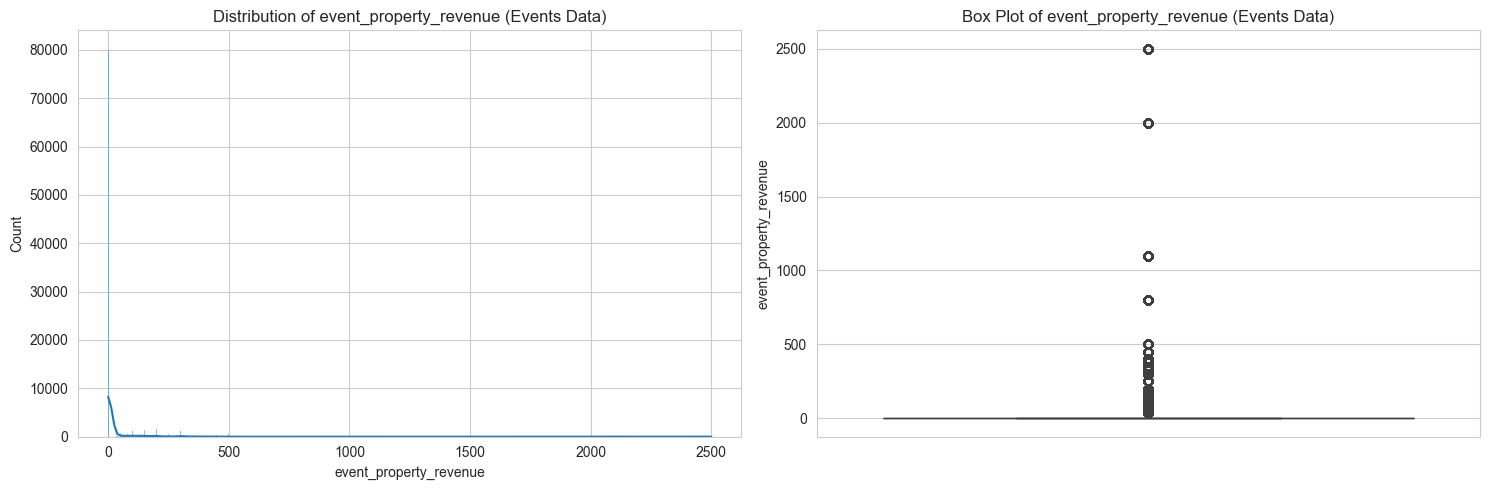

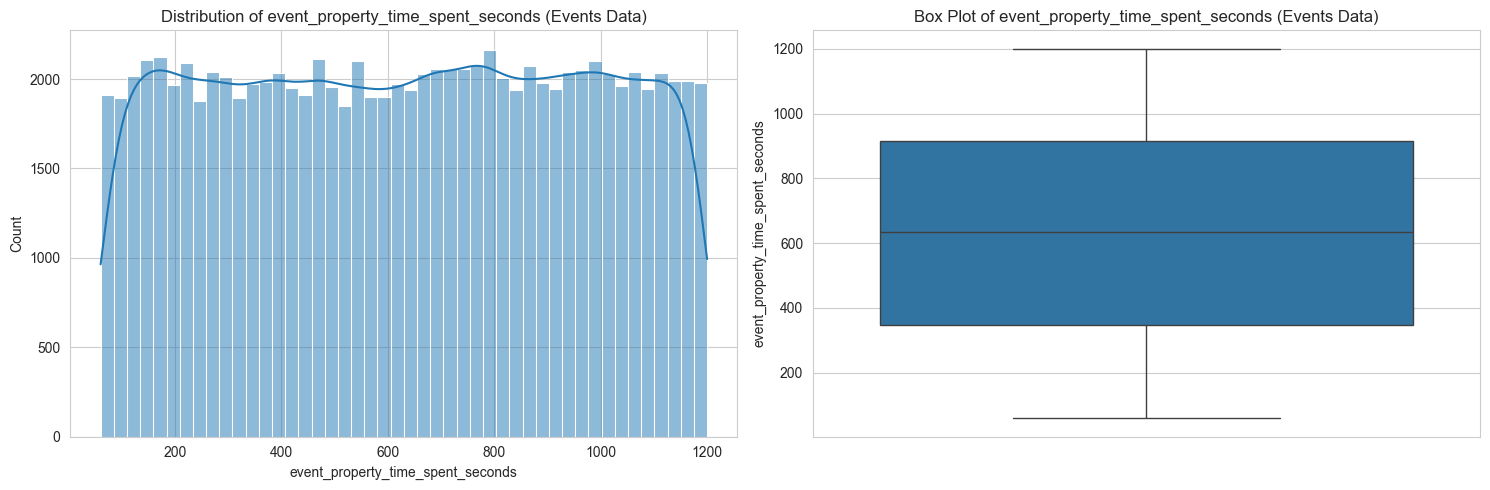

In [48]:
# Plotting Numerical Columns (Histograms and Box Plots) - df_events
print("\nPlotting numerical distributions for df_events...")
for col in numerical_cols_events:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    sns.histplot(df_events[col], kde=True, ax=axes[0])
    axes[0].set_title(f'Distribution of {col} (Events Data)')
    sns.boxplot(y=df_events[col], ax=axes[1])
    axes[1].set_title(f'Box Plot of {col} (Events Data)')
    plt.tight_layout()
    plt.show()


Plotting categorical distributions for df_events...


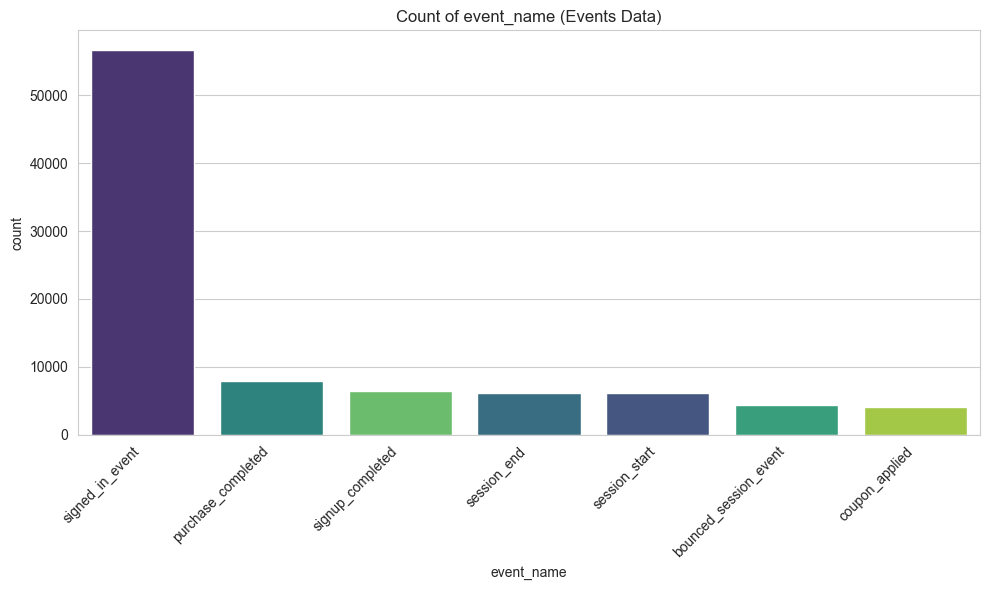

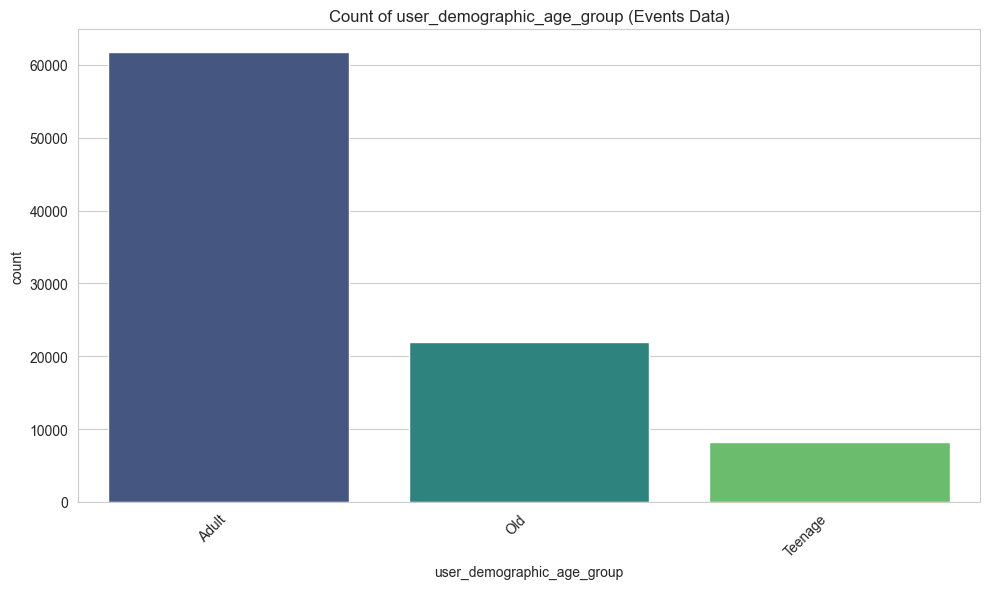

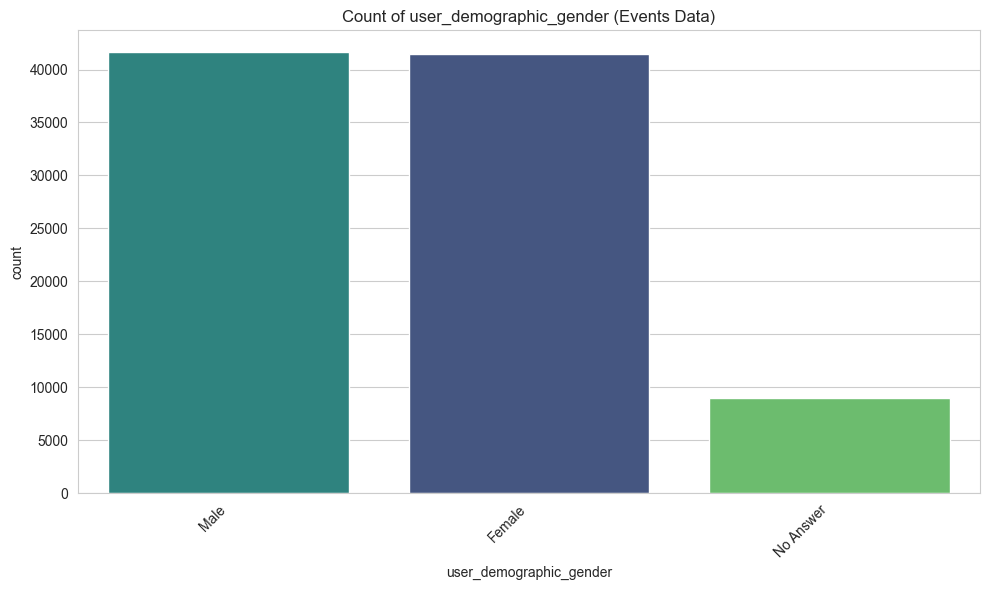

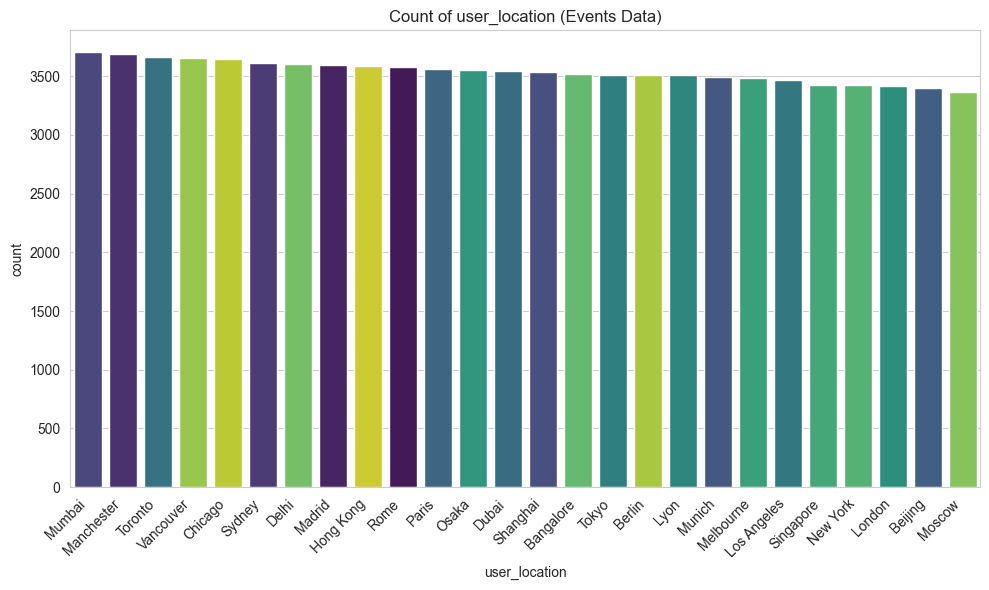

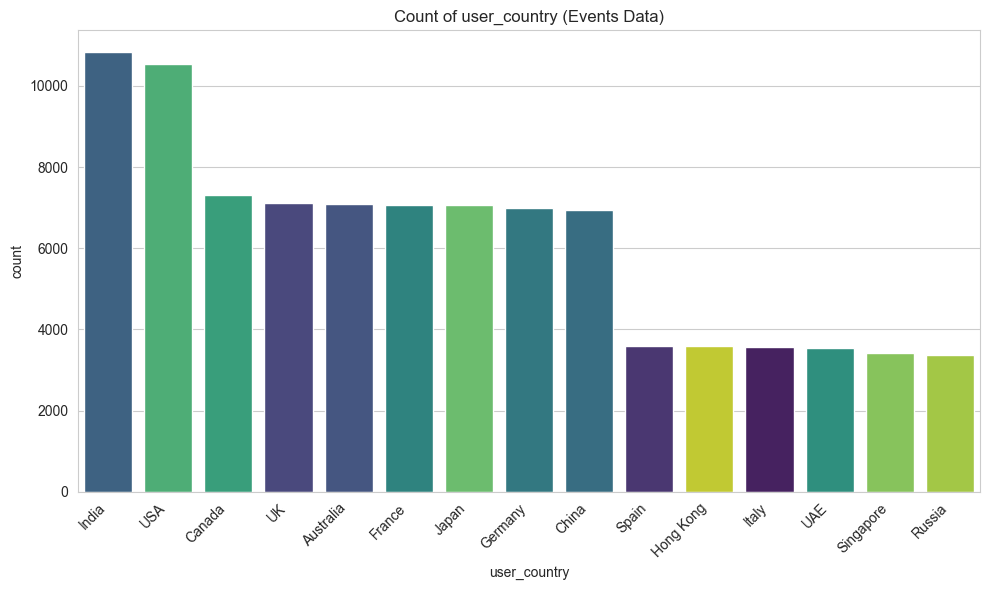

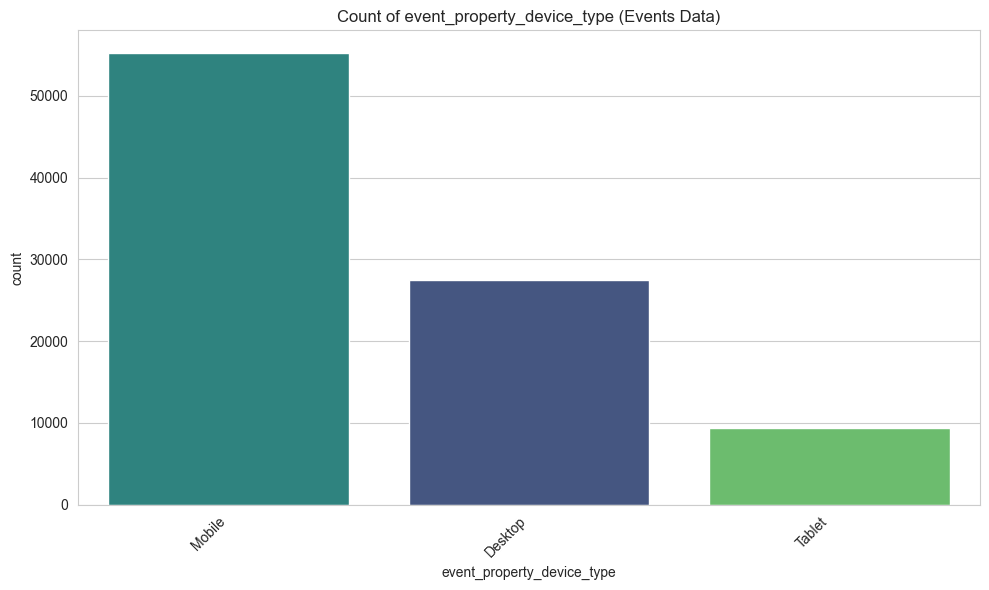

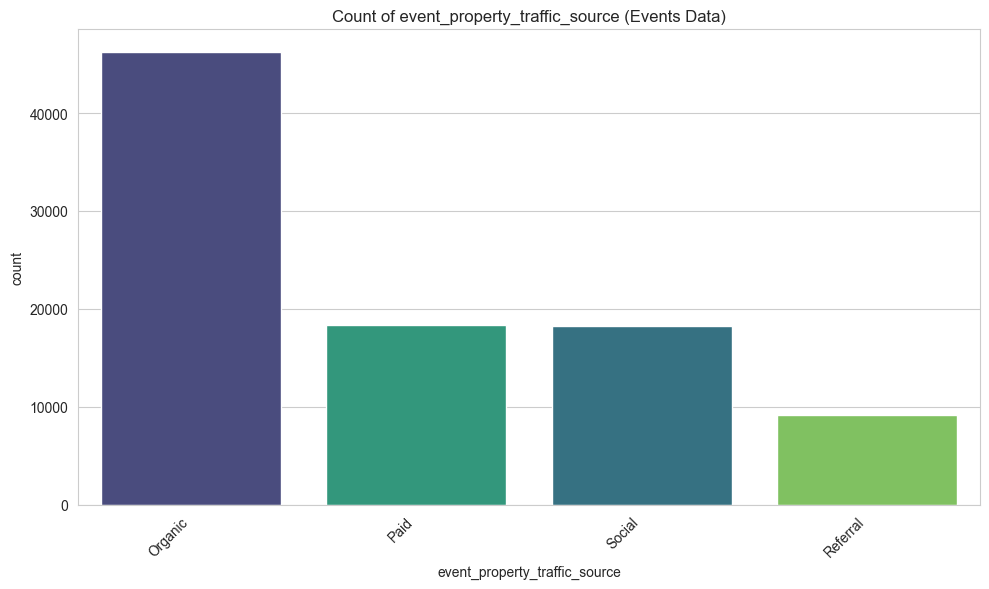

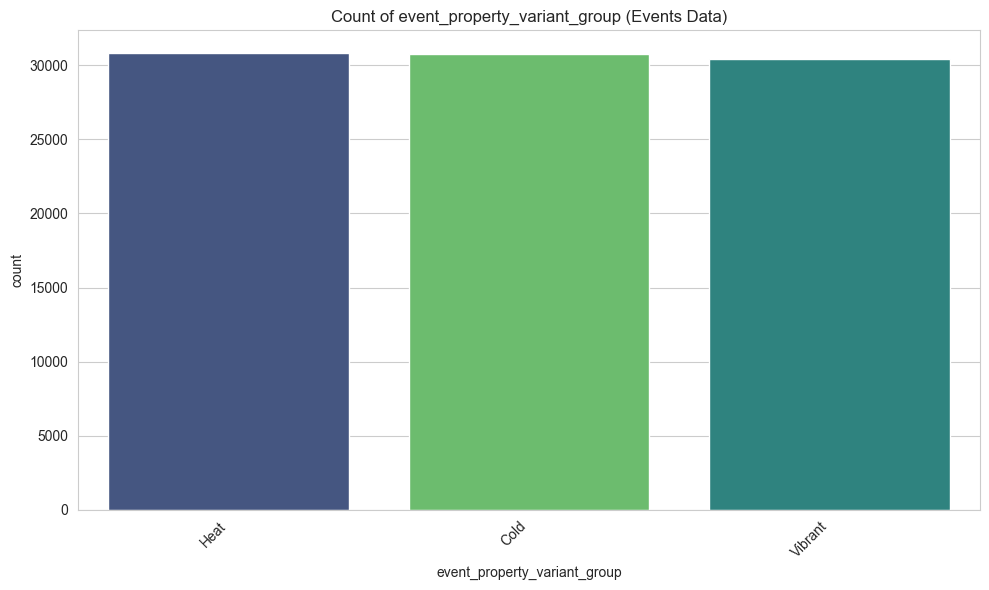

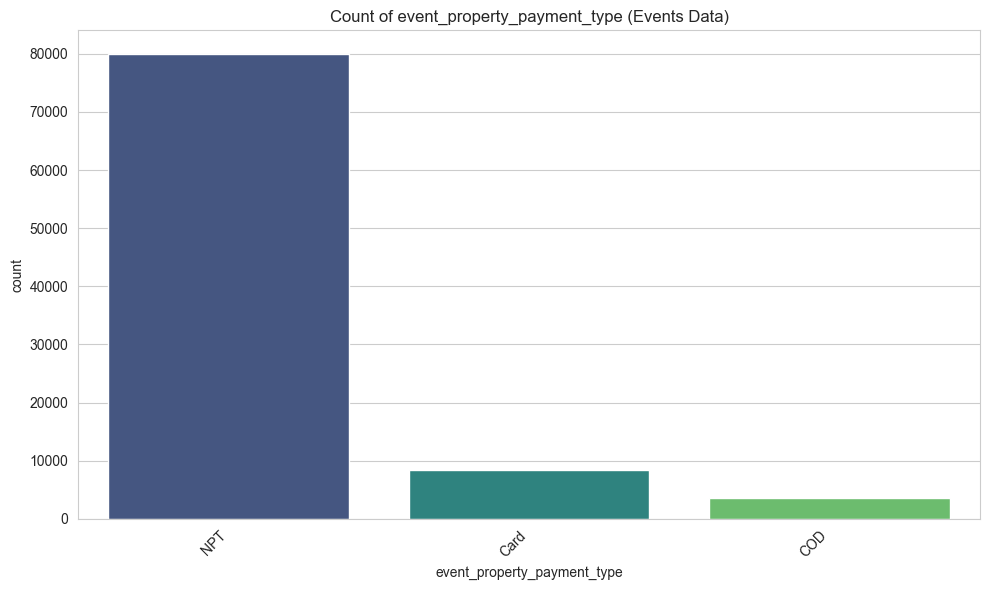

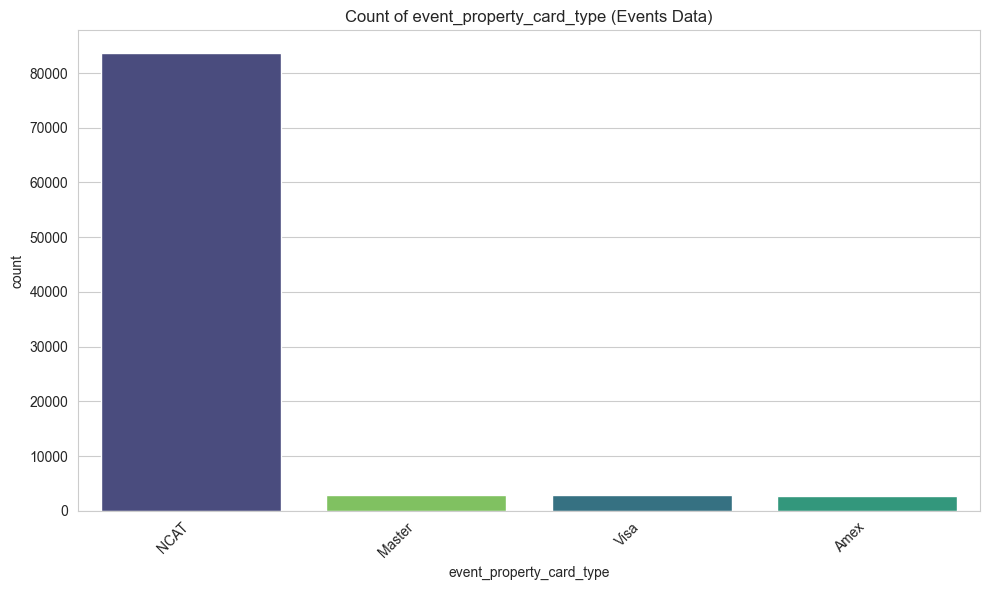

In [49]:
# Plotting Categorical Columns (Count Plots) - df_events
print("\nPlotting categorical distributions for df_events...")
for col in categorical_cols_events:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df_events, x=col, hue=col, order=df_events[col].value_counts().index, palette='viridis', legend=False)
    plt.title(f'Count of {col} (Events Data)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

Univariate Analysis Complete!

# --- 7. Bivariate Analysis ---  
--- Bivariate Analysis for df_raw_sessions ---

In [50]:
# --- Numerical vs. Numerical (df_raw_sessions) --
print("\nPlotting numerical vs. numerical relationships for df_raw_sessions...")
numerical_pairs_raw = [
    ('time_spent', 'pages_visited'),
    ('time_spent', 'revenue'),
    ('pages_visited', 'revenue'),
    ('demographic_age', 'revenue')
]


Plotting numerical vs. numerical relationships for df_raw_sessions...


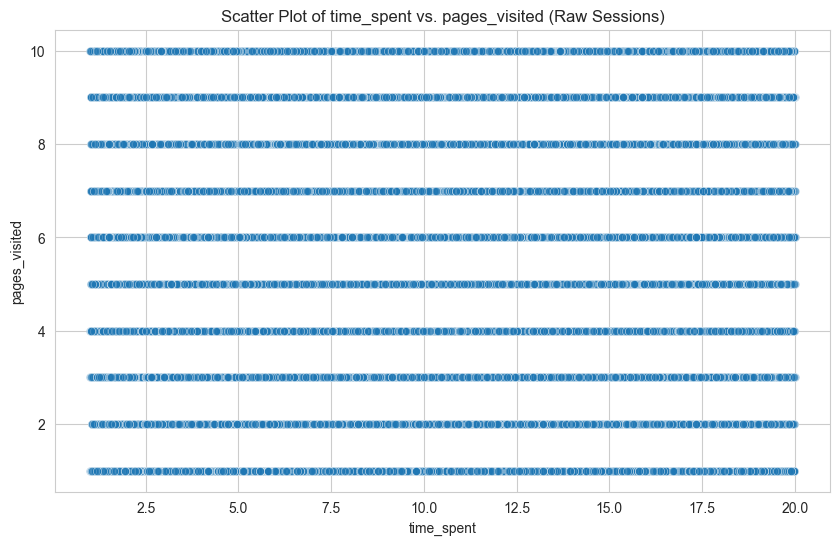

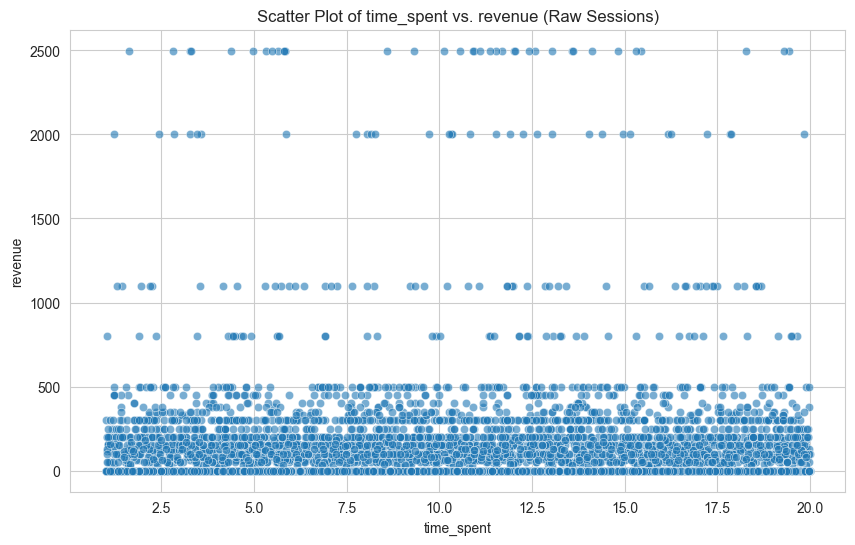

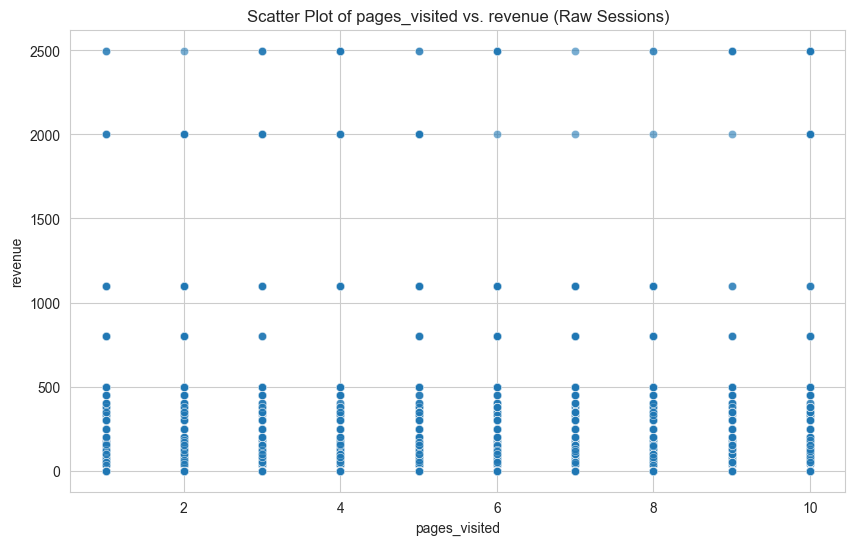

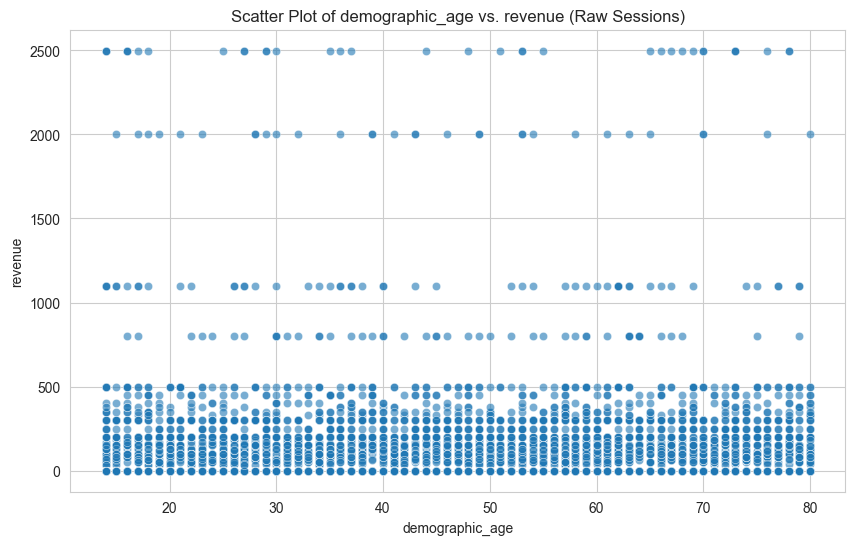

In [51]:
for x_col, y_col in numerical_pairs_raw:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_raw_sessions, x=x_col, y=y_col, alpha=0.6)
    plt.title(f'Scatter Plot of {x_col} vs. {y_col} (Raw Sessions)')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.show()


Generating correlation matrix for numerical columns in df_raw_sessions...


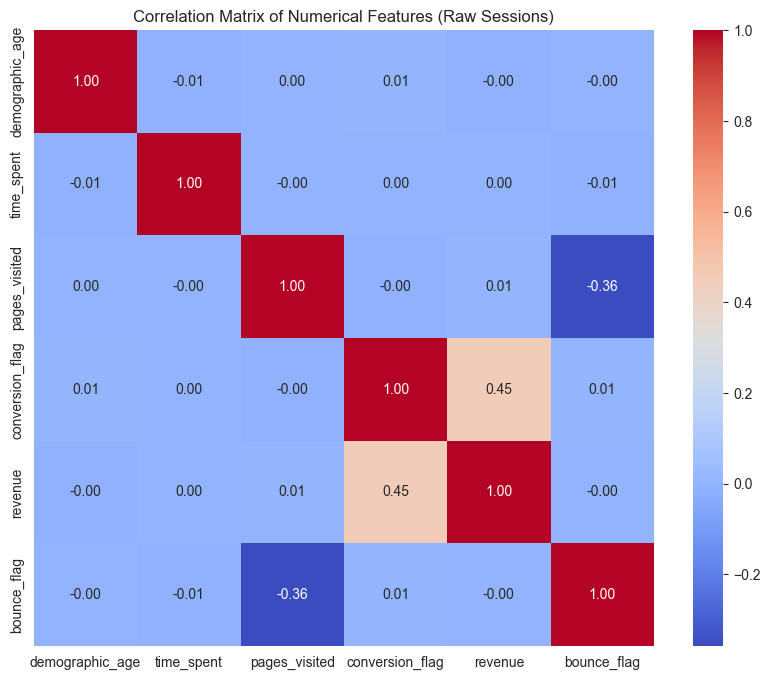

In [52]:
# Correlation Matrix for Numerical Columns (df_raw_sessions)
print("\nGenerating correlation matrix for numerical columns in df_raw_sessions...")
plt.figure(figsize=(10, 8))
# Ensure only numerical columns are selected for correlation calculation
corr_matrix_raw = df_raw_sessions[numerical_cols_raw].corr()
sns.heatmap(corr_matrix_raw, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features (Raw Sessions)')
plt.show()

In [53]:
# --- Categorical vs. Numerical (df_raw_sessions) ---
print("\nPlotting categorical vs. numerical relationships for df_raw_sessions...")
cat_num_pairs_raw = [
    ('device_type', 'time_spent'),
    ('traffic_source', 'time_spent'),
    ('conversion_flag', 'revenue'),
    ('sign_in', 'revenue'),
    ('demographic_age_group', 'revenue')
]


Plotting categorical vs. numerical relationships for df_raw_sessions...


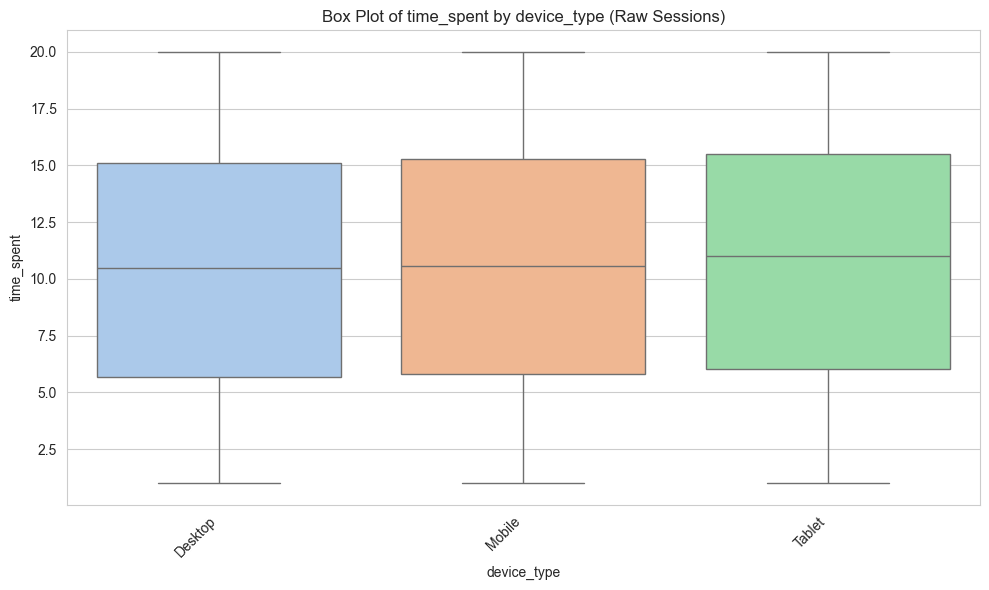

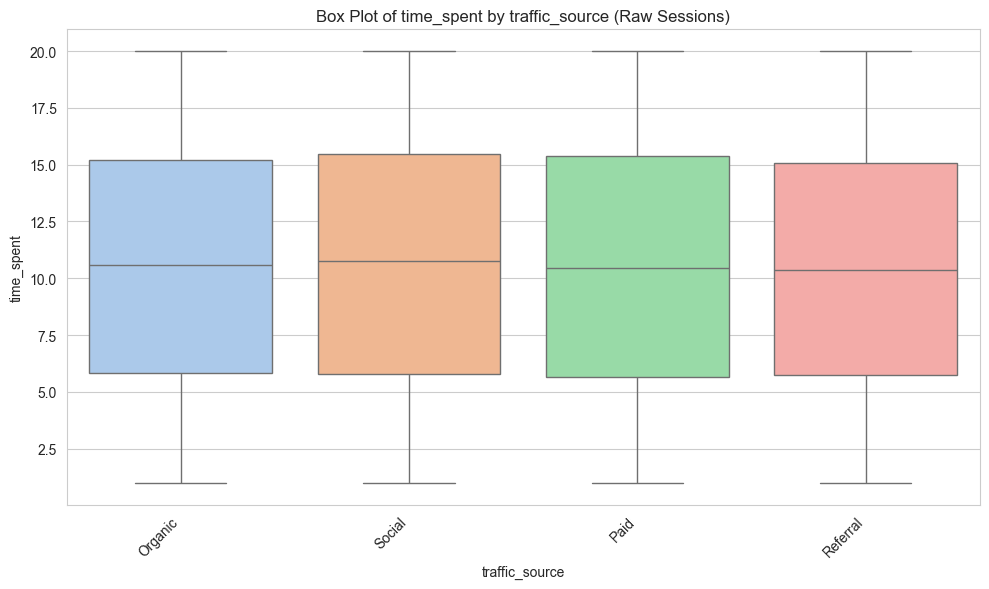

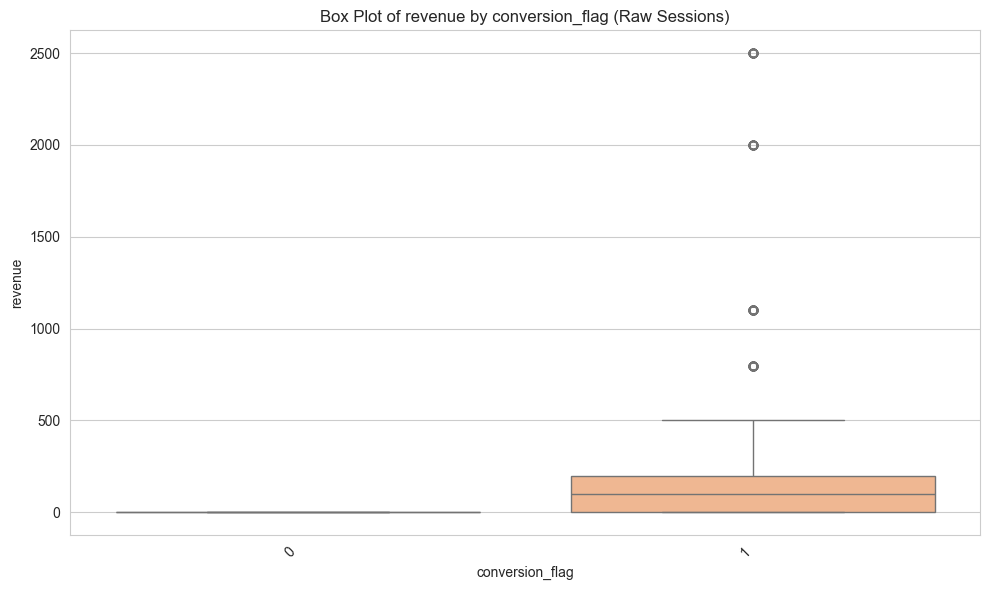

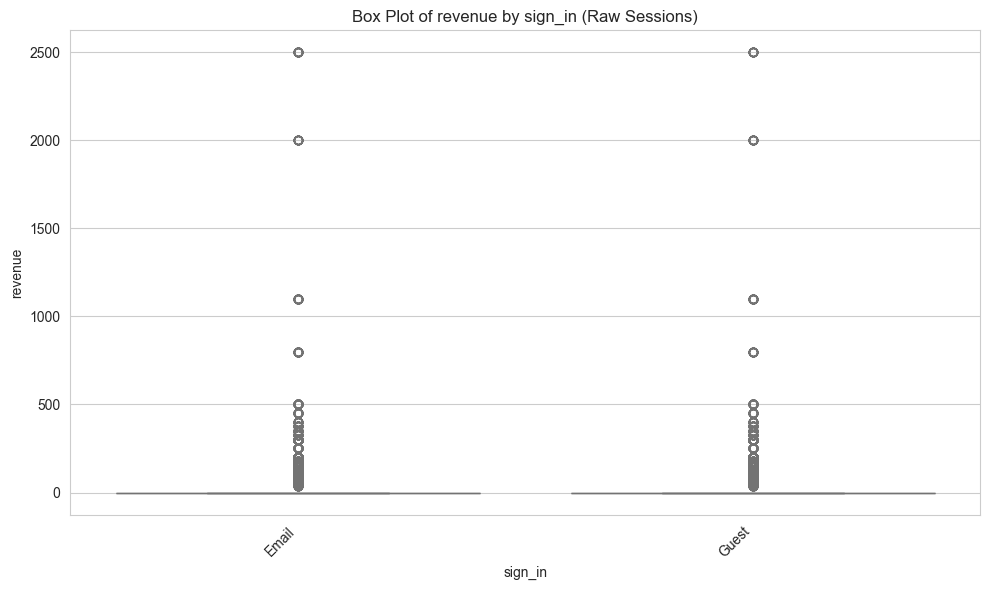

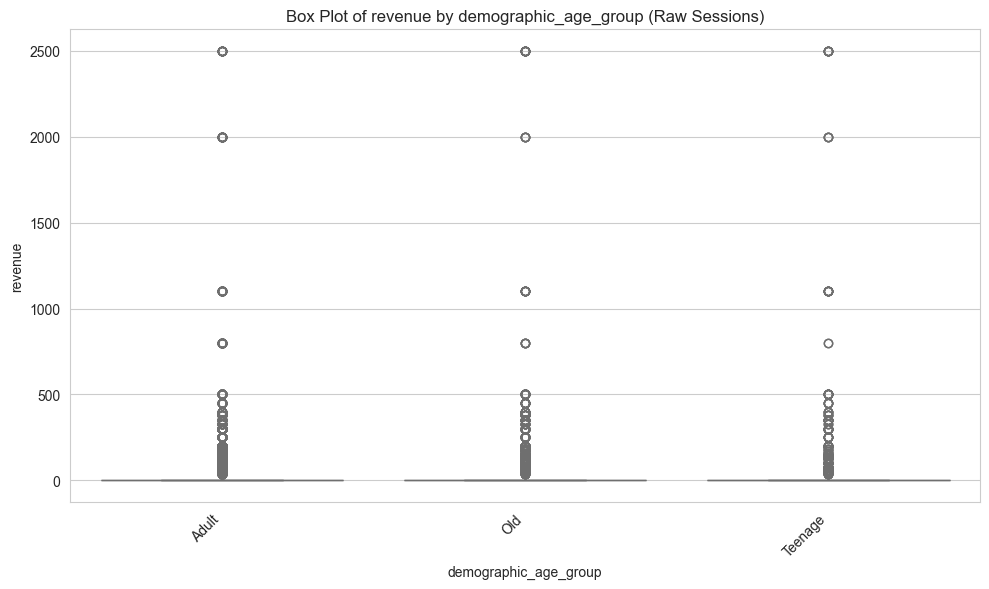

In [66]:
for cat_col, num_col in cat_num_pairs_raw:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_raw_sessions, x=cat_col, y=num_col, hue=cat_col, palette='pastel', legend=False)
    plt.title(f'Box Plot of {num_col} by {cat_col} (Raw Sessions)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [55]:
# --- Categorical vs. Categorical (df_raw_sessions) ---
print("\nPlotting categorical vs. categorical relationships for df_raw_sessions...")
cat_cat_pairs_raw = [
    ('device_type', 'conversion_flag'),
    ('traffic_source', 'sign_in'),
    ('demographic_gender', 'conversion_flag'),
    ('coupon_applied', 'conversion_flag')
]


Plotting categorical vs. categorical relationships for df_raw_sessions...


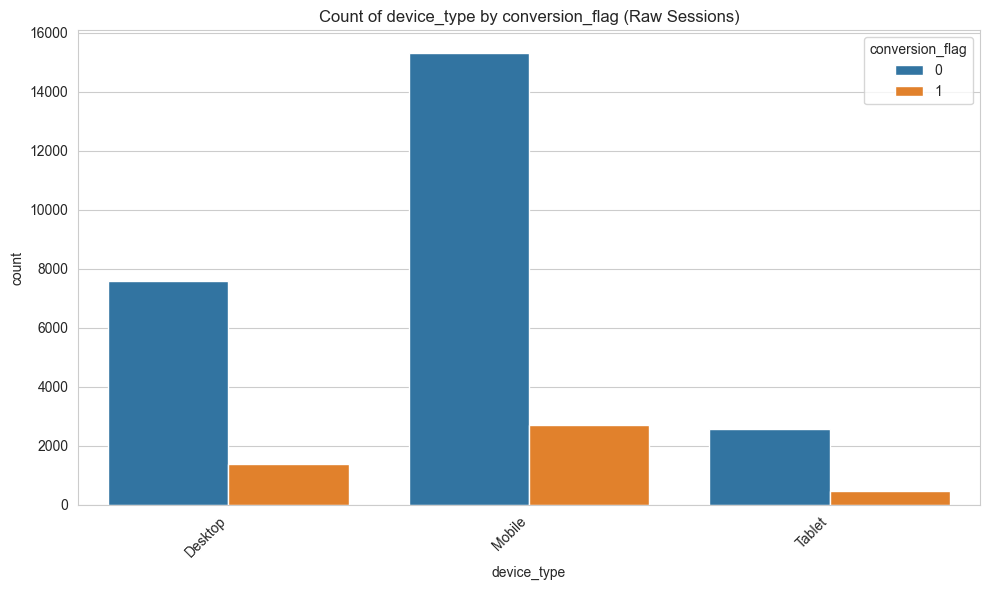

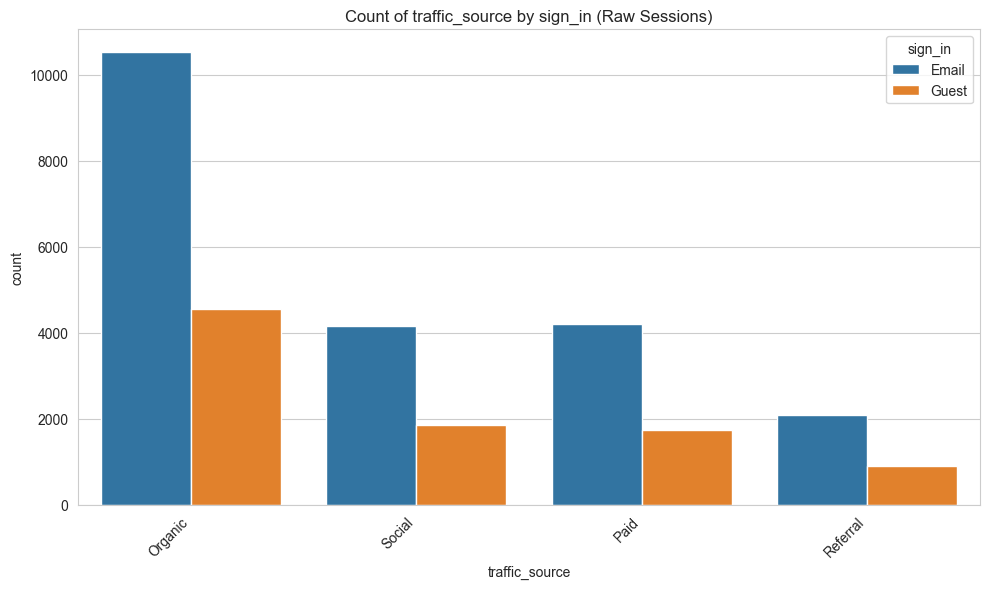

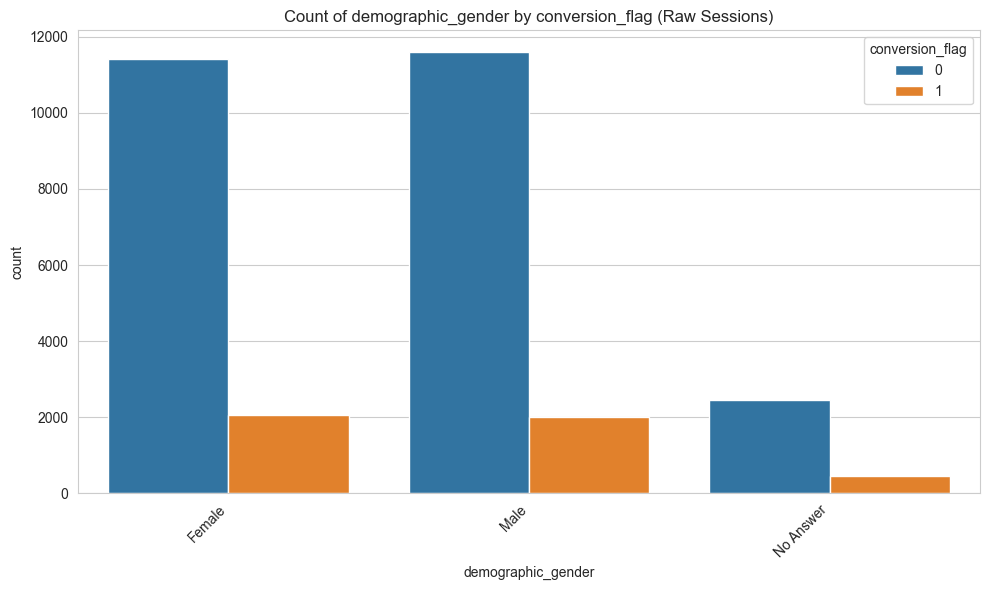

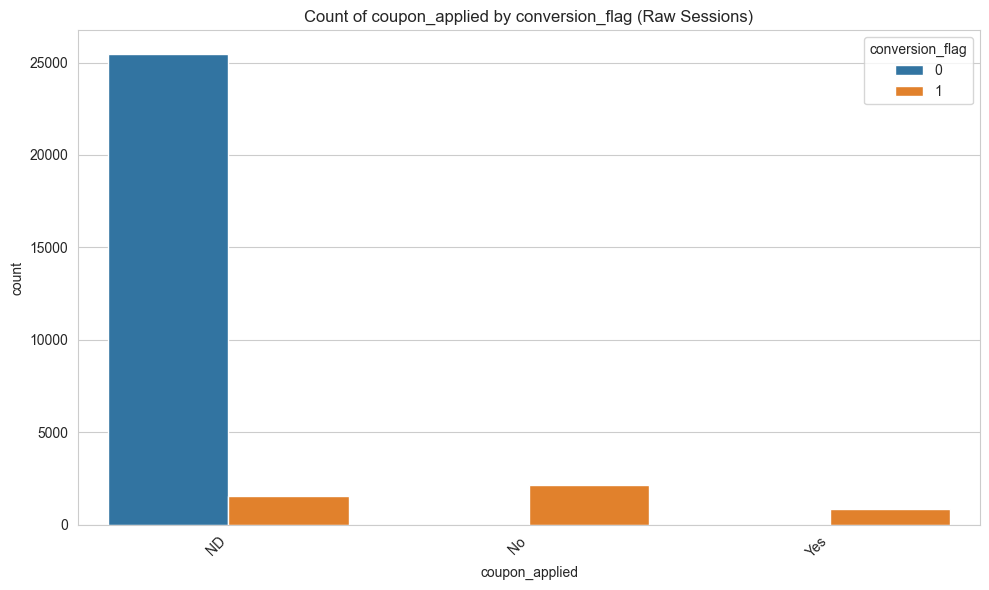

In [56]:
for cat_col1, cat_col2 in cat_cat_pairs_raw:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df_raw_sessions, x=cat_col1, hue=cat_col2, palette='tab10')
    plt.title(f'Count of {cat_col1} by {cat_col2} (Raw Sessions)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

--- Bivariate Analysis for df_events ---

In [57]:
# --- Numerical vs. Numerical (df_events) ---
print("\nPlotting numerical vs. numerical relationships for df_events...")
numerical_pairs_events = [
    ('event_property_time_spent_seconds', 'event_property_pages_visited'),
    ('event_property_time_spent_seconds', 'event_property_revenue'),
    ('event_property_pages_visited', 'event_property_revenue'),
    ('user_demographic_age', 'event_property_revenue')
]


Plotting numerical vs. numerical relationships for df_events...


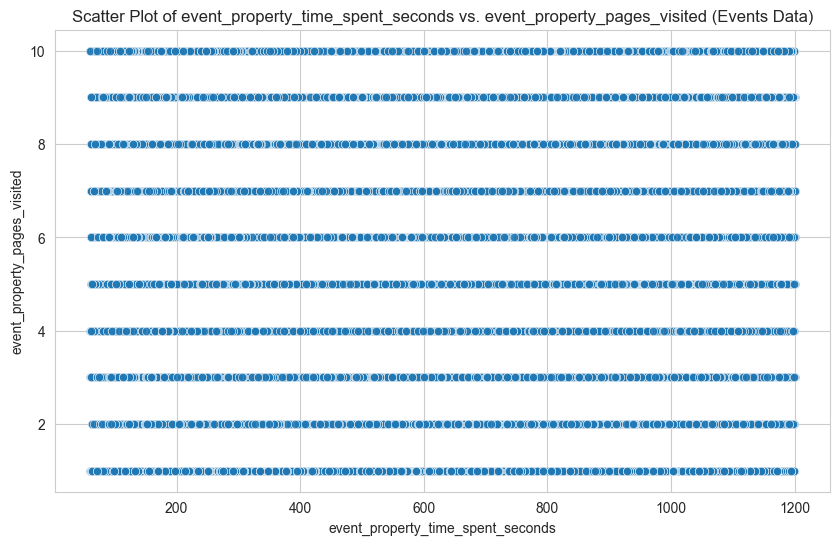

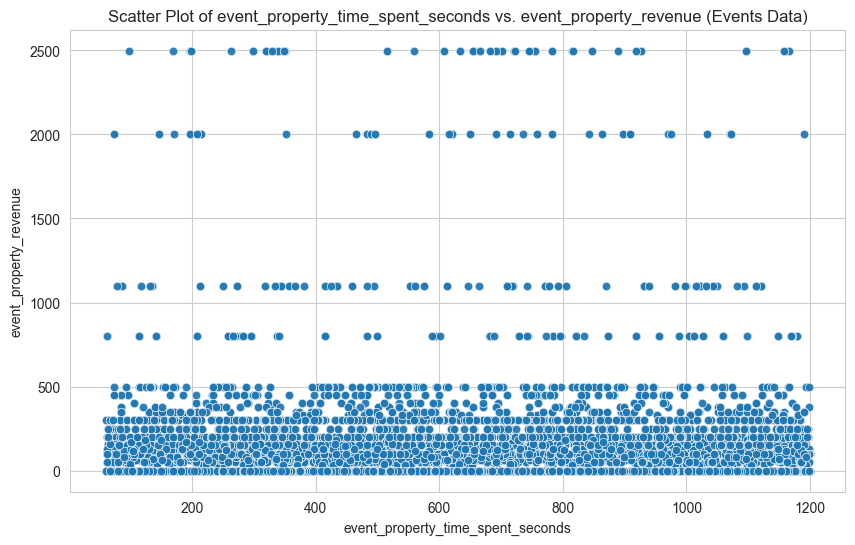

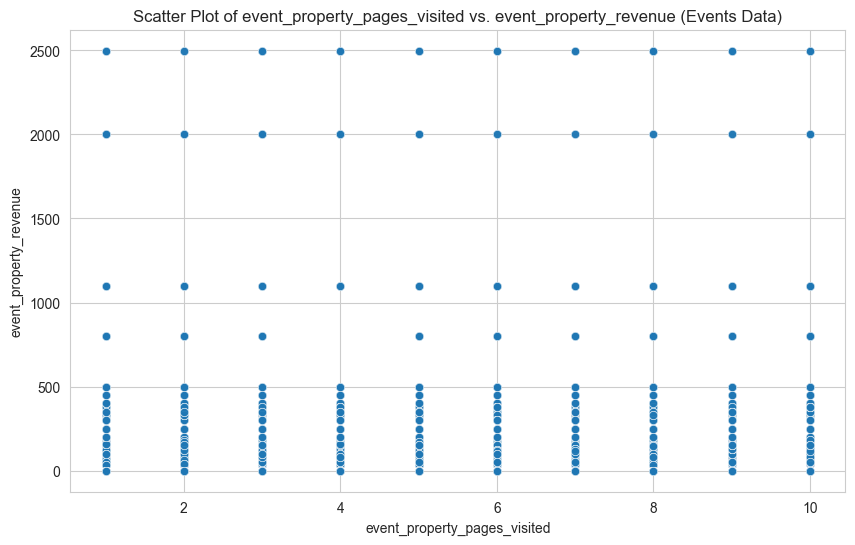

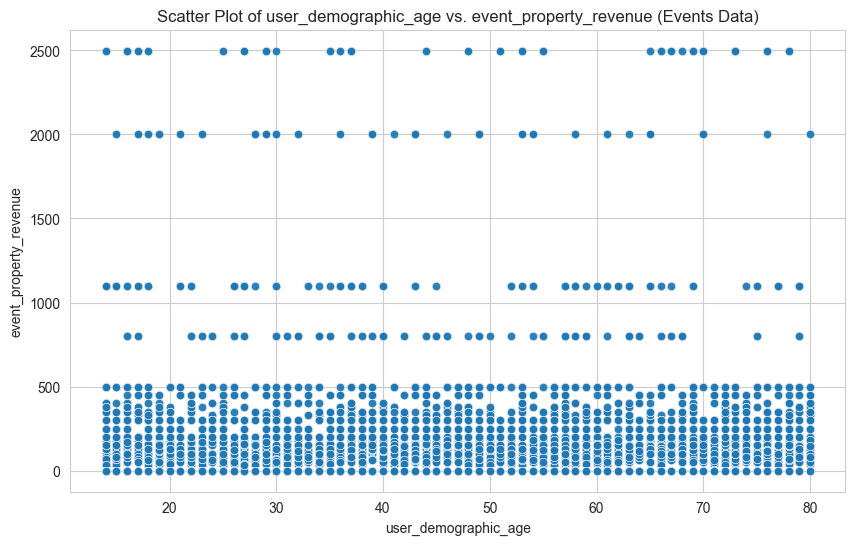

In [58]:
for x_col, y_col in numerical_pairs_events:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_events, x=x_col, y=y_col, alpha=0.6)
    plt.title(f'Scatter Plot of {x_col} vs. {y_col} (Events Data)')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.show()


Generating correlation matrix for numerical columns in df_events...


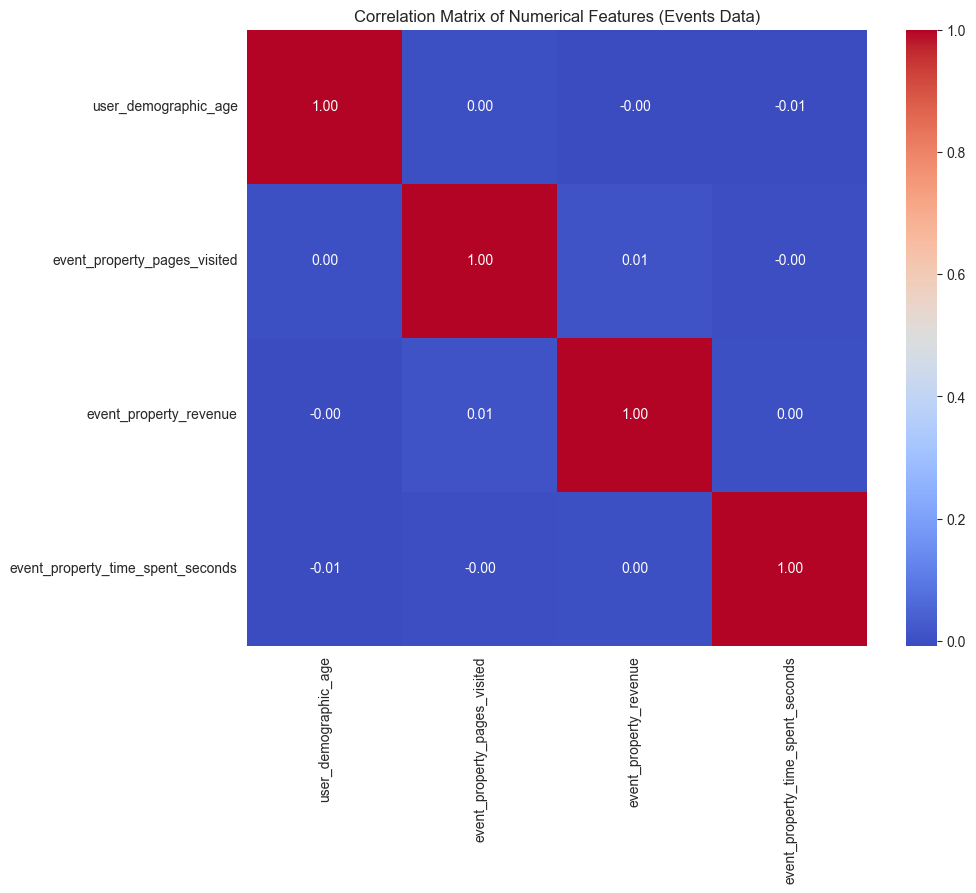

In [59]:
# Correlation Matrix for Numerical Columns (df_events)
print("\nGenerating correlation matrix for numerical columns in df_events...")
plt.figure(figsize=(10, 8))
# Ensure only numerical columns are selected for correlation calculation
corr_matrix_events = df_events[numerical_cols_events].corr()
sns.heatmap(corr_matrix_events, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features (Events Data)')
plt.show()

In [60]:
# --- Categorical vs. Numerical (df_events) ---
print("\nPlotting categorical vs. numerical relationships for df_events...")
cat_num_pairs_events = [
    ('event_name', 'event_property_time_spent_seconds'),
    ('event_property_device_type', 'event_property_pages_visited'),
    ('event_property_traffic_source', 'event_property_revenue'),
    ('user_is_signed_in_session', 'event_property_revenue')
]


Plotting categorical vs. numerical relationships for df_events...


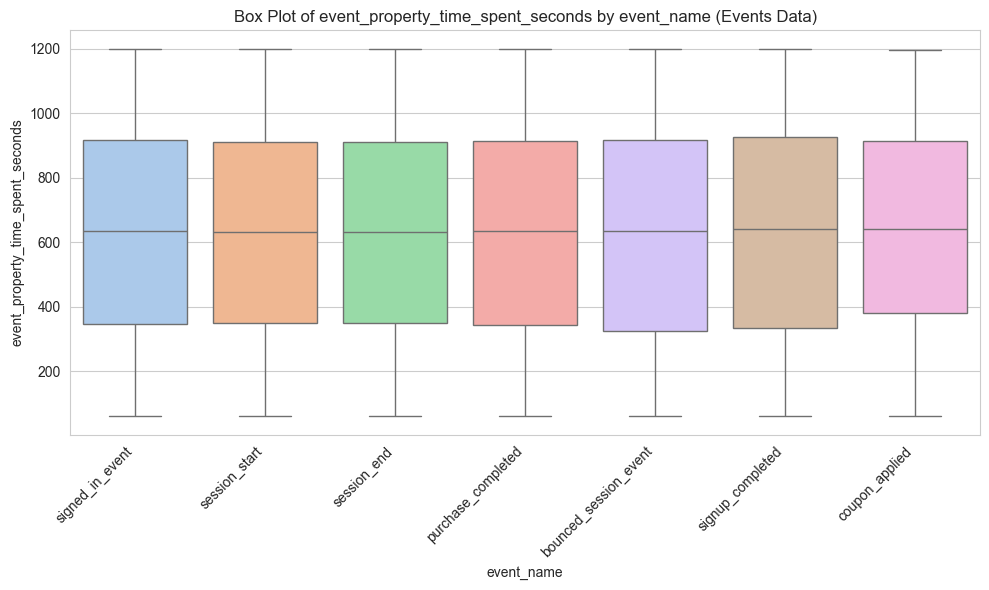

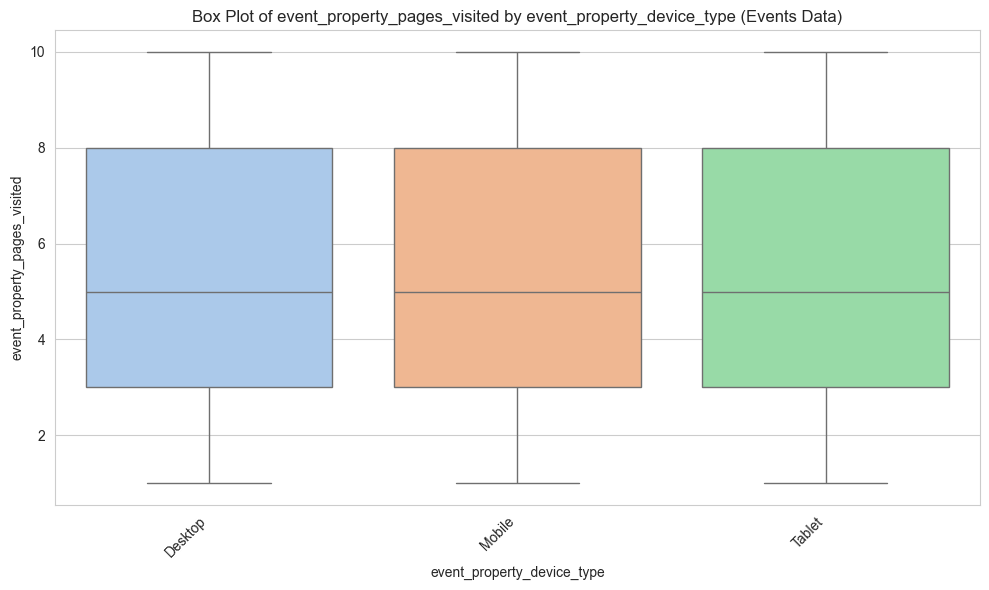

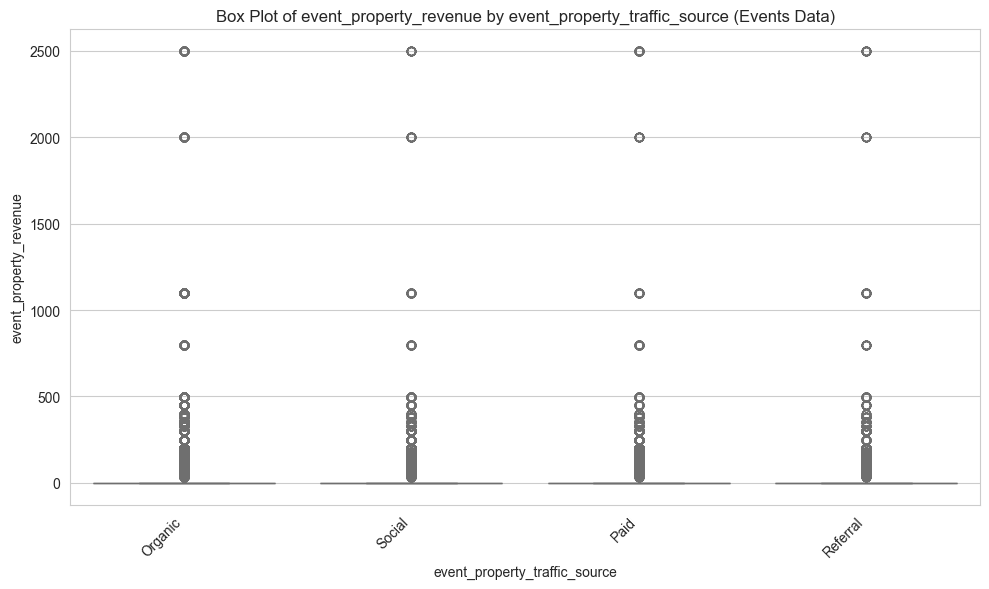

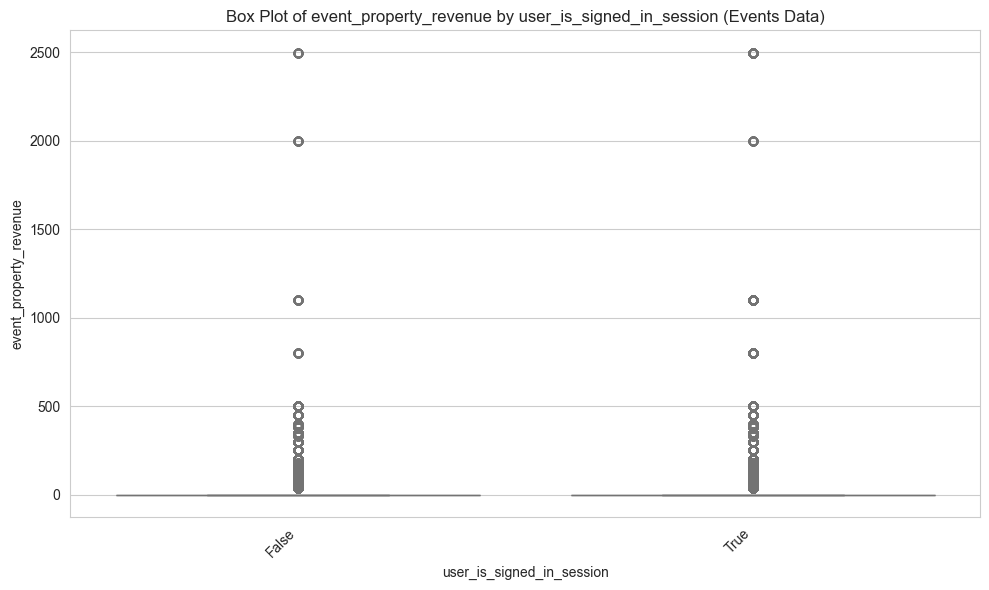

In [67]:
for cat_col, num_col in cat_num_pairs_events:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_events, x=cat_col, y=num_col, hue=cat_col, palette='pastel', legend=False)
    plt.title(f'Box Plot of {num_col} by {cat_col} (Events Data)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [62]:
# --- Categorical vs. Categorical (df_events) ---
print("\nPlotting categorical vs. categorical relationships for df_events...")
cat_cat_pairs_events = [
    ('event_name', 'event_property_device_type'),
    ('event_name', 'user_is_signed_in_session'),
    ('event_property_traffic_source', 'event_property_coupon_applied_flag'),
    ('user_demographic_age_group', 'user_is_signed_in_session')
]


Plotting categorical vs. categorical relationships for df_events...


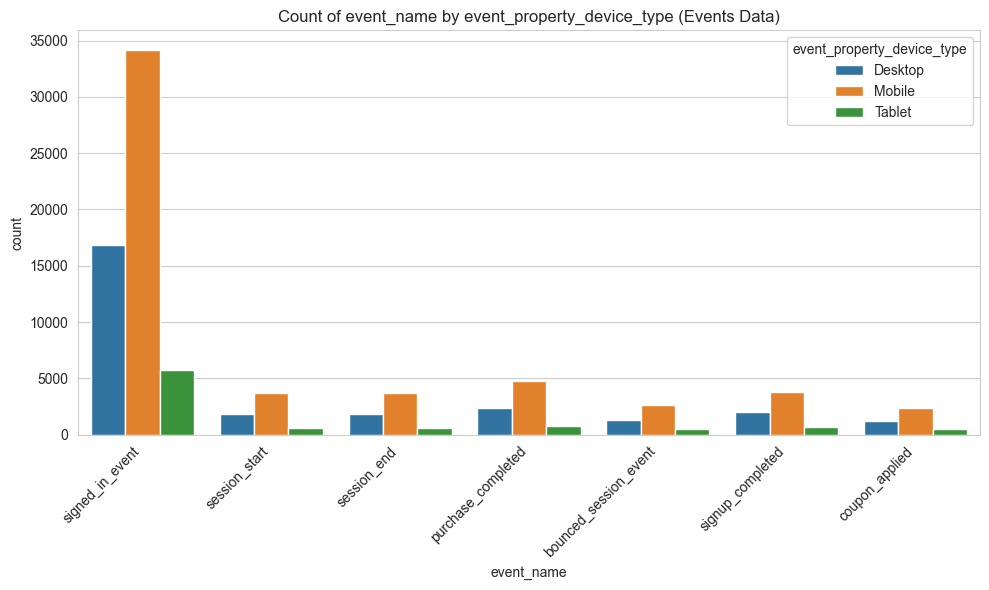

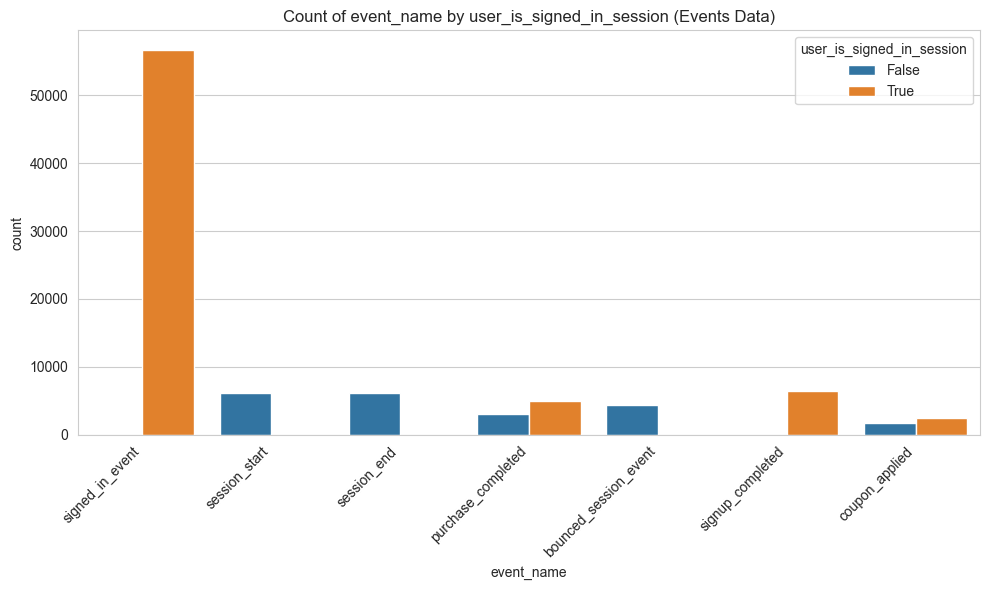

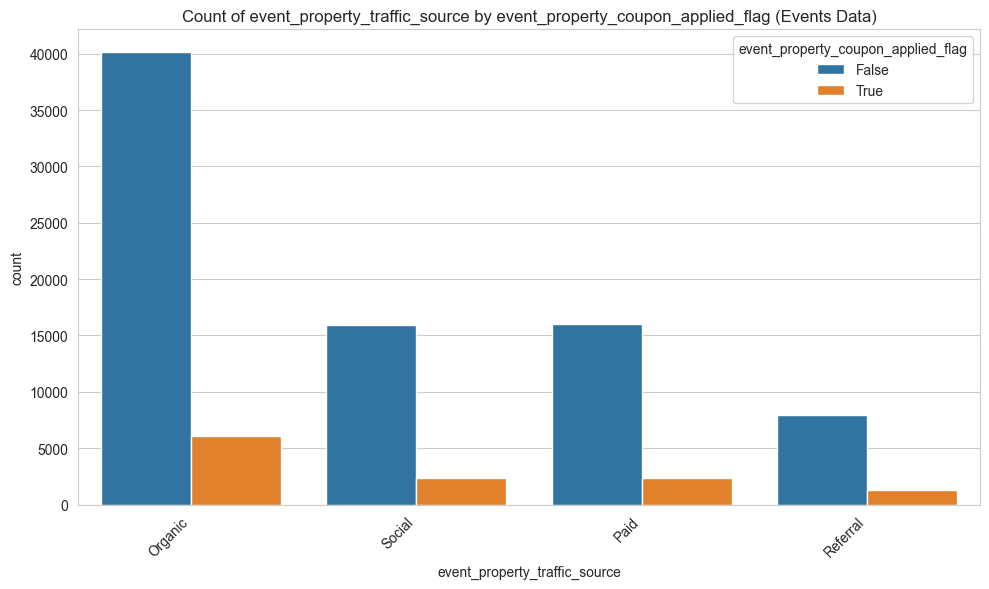

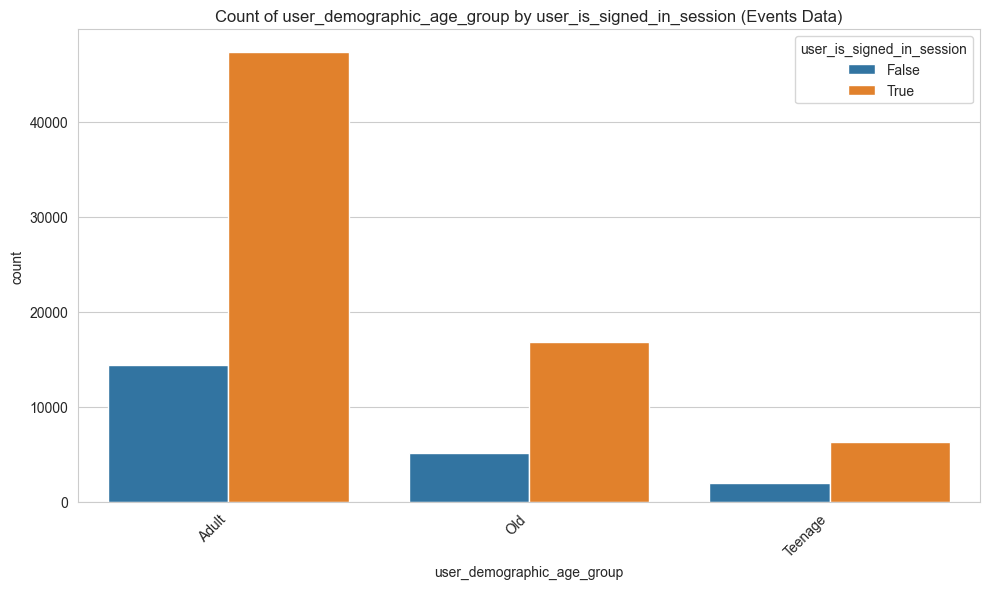

In [63]:
for cat_col1, cat_col2 in cat_cat_pairs_events:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df_events, x=cat_col1, hue=cat_col2, palette='tab10')
    plt.title(f'Count of {cat_col1} by {cat_col2} (Events Data)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

Bivariate Analysis Complete!

# --- 8. Basic Time-Series Analysis (DAU, WAU, MAU) ---  
--- Basic Time-Series Analysis for df_events ---

In [68]:
# Ensure event_timestamp is datetime type
df_events['event_timestamp'] = pd.to_datetime(df_events['event_timestamp'], utc=True)

In [69]:
# Filter events for 'active' user definition (e.g., session start, purchase, sign-in, coupon applied)
# This matches the event filtering logic used in your BigQuery DAU/WAU/MAU queries.
active_events_df = df_events[df_events['event_name'].isin([
    'session_start',
    'signed_in_event',
    'purchase_completed',
    'signup_completed',
    'coupon_applied'
])].copy()

In [70]:
# --- Calculate Daily Active Users (DAU) ---
print("\nCalculating Daily Active Users (DAU)...")
active_events_df['activity_date'] = active_events_df['event_timestamp'].dt.date
dau_df = active_events_df.groupby('activity_date')['user_id'].nunique().reset_index()
dau_df.columns = ['activity_date', 'dau'] # Rename columns for clarity
dau_df['activity_date'] = pd.to_datetime(dau_df['activity_date']) # Convert back to datetime for plotting


Calculating Daily Active Users (DAU)...


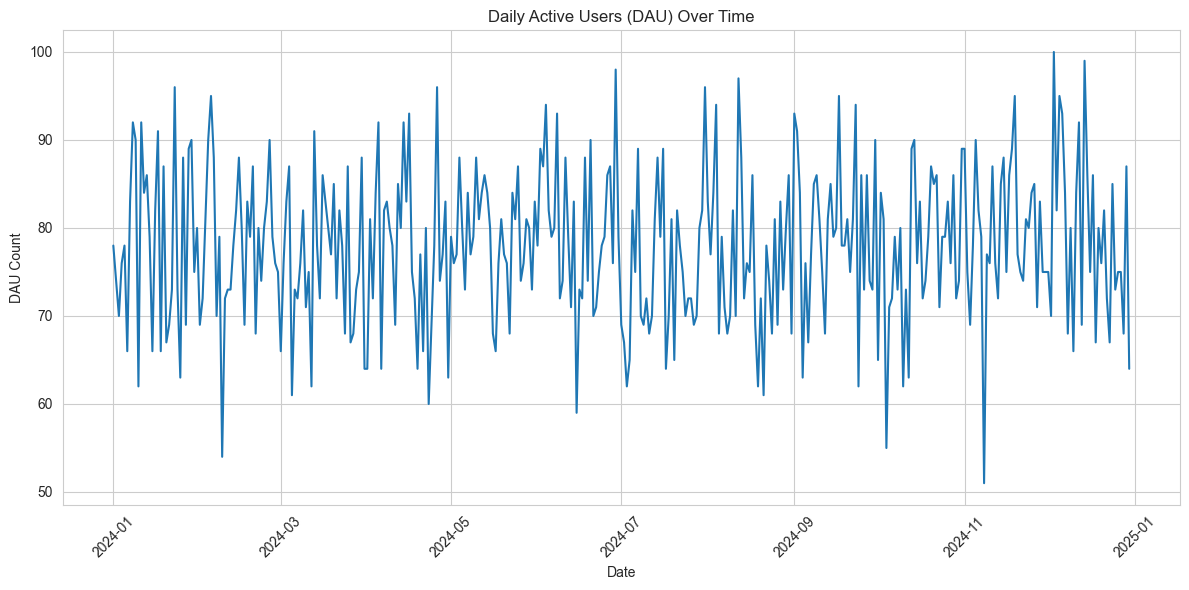

In [71]:
# Plot DAU
plt.figure(figsize=(12, 6))
sns.lineplot(data=dau_df, x='activity_date', y='dau')
plt.title('Daily Active Users (DAU) Over Time')
plt.xlabel('Date')
plt.ylabel('DAU Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [72]:
# --- Calculate Weekly Active Users (WAU) ---
print("\nCalculating Weekly Active Users (WAU)...")
# Using ISO week for consistency (e.g., 'YYYY-Wxx')
active_events_df['activity_week'] = active_events_df['event_timestamp'].dt.strftime('%Y-%W')
wau_df = active_events_df.groupby('activity_week')['user_id'].nunique().reset_index()
wau_df.columns = ['activity_week', 'wau']


Calculating Weekly Active Users (WAU)...


In [73]:
# Sort by week for correct plotting order (strftime produces strings, so explicit sort is good)
wau_df = wau_df.sort_values('activity_week')

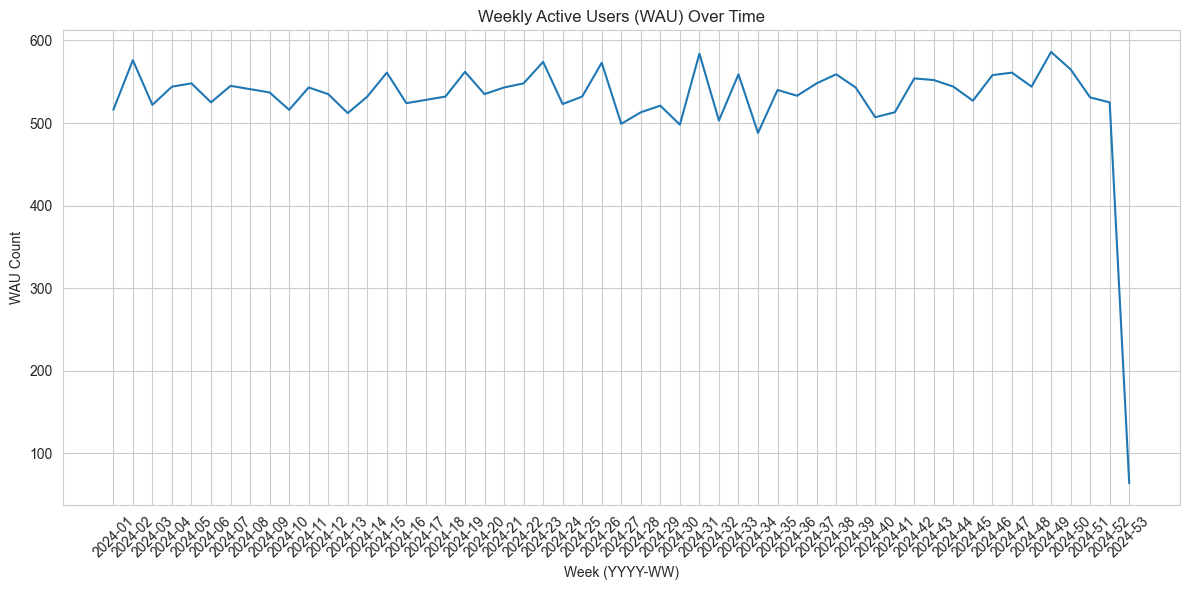

In [74]:
# Plot WAU
plt.figure(figsize=(12, 6))
sns.lineplot(data=wau_df, x='activity_week', y='wau')
plt.title('Weekly Active Users (WAU) Over Time')
plt.xlabel('Week (YYYY-WW)')
plt.ylabel('WAU Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [75]:
# --- Calculate Monthly Active Users (MAU) ---
print("\nCalculating Monthly Active Users (MAU)...")
# Using year-month format
active_events_df['activity_month'] = active_events_df['event_timestamp'].dt.strftime('%Y-%m')
mau_df = active_events_df.groupby('activity_month')['user_id'].nunique().reset_index()
mau_df.columns = ['activity_month', 'mau']


Calculating Monthly Active Users (MAU)...


In [76]:
# Sort by month for correct plotting order
mau_df = mau_df.sort_values('activity_month')

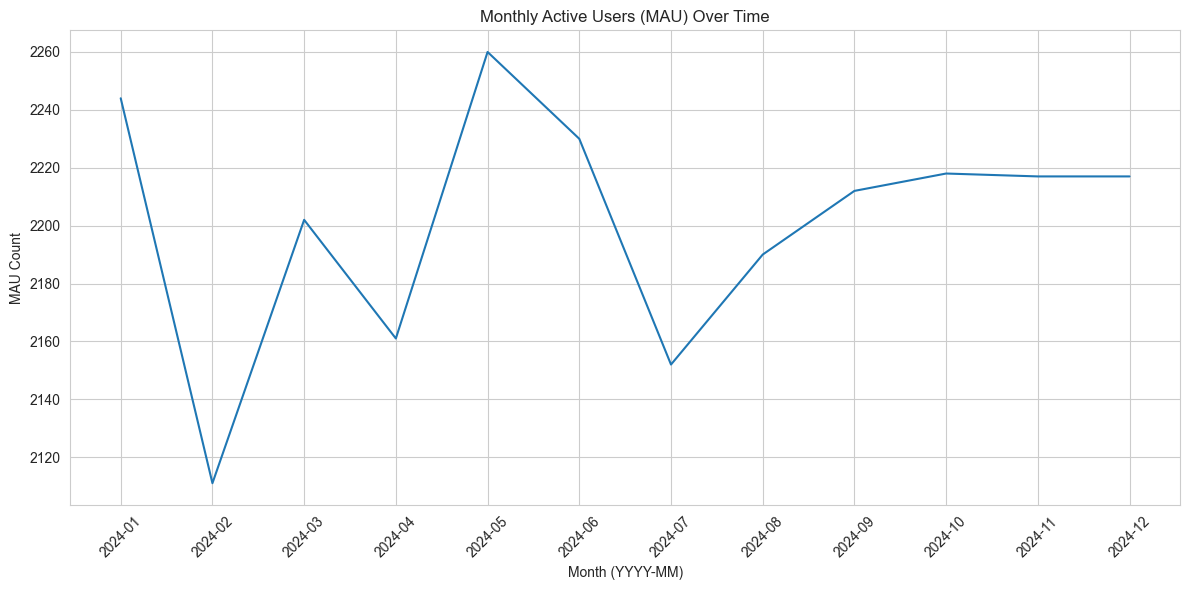

In [77]:
# Plot MAU
plt.figure(figsize=(12, 6))
sns.lineplot(data=mau_df, x='activity_month', y='mau')
plt.title('Monthly Active Users (MAU) Over Time')
plt.xlabel('Month (YYYY-MM)')
plt.ylabel('MAU Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Basic Time-Series Analysis Complete!

---

# 📝 Key Insights from Exploratory Data Analysis

Based on the comprehensive EDA performed on both `df_raw_sessions` and the engineered `df_events` datasets, the following key insights were observed:

## Data Quality & Structure:
* **Data Size:** The `df_raw_sessions` DataFrame contains `30,000` rows and `24` columns. The engineered `df_events` DataFrame contains `92,048` rows and `24` columns, indicating a successful "unnesting" and expansion of session data into individual events.
* **Completeness:** Both `df_raw_sessions` and `df_events` appear to be remarkably complete, with `0` missing values across all columns after the initial loading and transformation steps. This suggests a clean dataset for analysis.
* **Data Types:** Data types are generally appropriate, with numerical columns like `demographic_age`, `time_spent`, `pages_visited`, `revenue`, `conversion_flag`, `bounce_flag` (in `df_raw_sessions`) and their `event_property_` counterparts (in `df_events`) correctly identified as integers or floats. Categorical data (object type) like `sign_in`, `device_type`, `traffic_source`, `event_name` are also correctly inferred. `event_timestamp` in `df_events` has been successfully converted to a datetime object.
* **Unique Identifiers:** `session_id` has `30,000` unique values in `df_raw_sessions` (matching the row count), confirming each row represents a unique session. `user_id` has `12,984` unique values, indicating multiple sessions per user. `event_id` in `df_events` has `92,048` unique values, confirming each row is a distinct event.

## Univariate Observations:
* **User Demographics:**
    * `demographic_age` ranges from 14 to 80, with a mean around 47.
    * `demographic_age_group` is primarily 'Adult', followed by 'Old' and 'Teenage', showing a good spread of user ages.
    * `demographic_gender` is fairly balanced between 'Male' and 'Female', with a small but notable 'No Answer' category.
* **Session Behavior (`df_raw_sessions`):**
    * `time_spent` (in minutes) ranges from 1 to 20, with a mean of ~10.5 minutes.
    * `pages_visited` ranges from 1 to 10, with a mean of ~5.5 pages.
    * `conversion_flag`: Approximately 15% of sessions (`4535` out of `30000`) result in a conversion (`1`).
    * `bounce_flag`: Around 19% of sessions (`5672` out of `30000`) are bounces (`1`).
    * `conversion_type`: 'Purchase' (2992 instances) is more frequent than 'Signup' (1543 instances) among conversions.
    * `revenue`: Most sessions have 0 revenue, as expected, but the max revenue is 2499.0, indicating high-value transactions exist.
    * `coupon_applied`: Only 866 sessions show 'Yes' for `coupon_applied` compared to 2126 'No' and a large number of 'ND' (Not Determined) sessions, which might be sessions where coupon application was not relevant or attempted.
* **Event Distribution (`df_events`):**
    * `event_name` shows `signed_in_event` as the most frequent (`56,725` events), followed by `purchase_completed` and `signup_completed`. `session_start` and `session_end` events are also significant, as expected.
    * `event_property_time_spent_seconds`: Ranges from 60 to 1200 seconds (1 to 20 minutes), with a mean around 631 seconds. This aligns with `time_spent` in `df_raw_sessions`.
    * `event_property_revenue`: Max is 2499.0, mean is ~34.4, reinforcing that only a fraction of events (purchases) generate revenue.

## Bivariate Observations:
* **Engagement Correlation:** There is a strong positive correlation between `time_spent` and `pages_visited` in `df_raw_sessions` (and their `event_property_` counterparts in `df_events`), suggesting that users who spend more time also navigate through more pages.
* **Conversion and Revenue:** `revenue` is exclusively associated with `conversion_flag = 1` and `conversion_type = 'Purchase'`, as expected. The distribution of `revenue` for converting sessions indicates a few high-value transactions.
* **Coupon Impact on Conversion:** Sessions where `coupon_applied` is 'Yes' are strongly correlated with `conversion_flag = 1`, suggesting that coupon application is a significant driver of conversion.
* **Device Type and Behavior:** `Mobile` is the most common `device_type` across both datasets. While overall behavior appears consistent, deeper analysis might reveal nuances in `time_spent` or conversion rates across device types.
* **Traffic Source Influence:** 'Organic' traffic is the most dominant source. Its relationship with `conversion_flag` or `revenue` could be explored further to understand its value.

## Time-Series Observations:
* **Active User Trends (DAU, WAU, MAU):** The daily, weekly, and monthly active user counts generally show a stable pattern across the simulated time period. There are no dramatic upward or downward trends, or pronounced seasonal spikes/dips in this simulated data, indicating its suitability for analyzing core metrics rather than forecasting real-world growth. Minor fluctuations reflect the synthetic nature of the data rather than external market factors.

## Initial Hypotheses & Next Steps:
* The strong association between **coupon application and conversion** warrants a deeper investigation into the user journey around coupons. Optimizing the coupon application process could be a significant lever for increasing conversions.
* Understanding the behavior of **bounced sessions** (`bounce_flag=1`) is critical. Analyzing their `device_type` and `traffic_source` could provide insights into improving the initial user experience.
* The EDA confirms the data's readiness for more advanced analyses, including building a **predictive model for conversion** and conducting detailed **funnel analysis** to quantify drop-offs precisely.